In [1]:
import domain_adapt_run.domain_adapt_run.constants as constants
cache_folder_name = 'SDR_DA_clean'
seed = 44

In [2]:
import autograd.numpy as np
np.random.seed(seed)
import python_utils.python_utils.basic as basic
import python_utils.python_utils.caching as caching
log_folder = '%s/%s' % (constants.cache_folder, cache_folder_name)
caching.init(constants.cache_folder, constants.which_hash, basic.archiver(log_folder))
%load_ext autoreload
%autoreload 2

[Errno 17] File exists: '/Users/fultonw/Documents/projects/runs/domain_adapt_run/cache/SDR_DA_clean'


In [3]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display_pretty, display_html
import python_utils.python_utils.basic as basic
import pandas as pd
import pdb
import itertools
import functools
import scipy.stats, scipy
import cvxopt
import domain_adapt.domain_adapt.kernels as kernels
import pymanopt
import pprint, autograd
import scipy.optimize
import domain_adapt.domain_adapt.SDR_data as SDR_data
import domain_adapt.domain_adapt.SDR_constructor as SDR_constructor
import sklearn
from sklearn import grid_search, linear_model, pipeline

Couldn't import dot_parser, loading of dot files will not be possible.


/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
# get data
x_dim = 2
u_dim = 1
v_dim = 1
num_train = 200
num_test = 200
xs_train, xs_test, ys_train, ys_test = SDR_data.logreg_data(x_dim, u_dim, v_dim, num_train, num_test)

In [5]:
# construct a estimator
num_trials = 1
num_anneals = 1
B_max = 10
KMM_eps = 0.001
tradeoff = 10.
reg = 5.
lin_solver = lambda A,b: scipy.sparse.linalg.lsmr(A,b)[0]
cvxopt_solver = kernels.cvxopt_solver
obj_from_wsopt_and_Ks, dobj_dwsopt, get_dobj_dP_thru_Ku = SDR_constructor.get_logreg_obj_and_gradients(lin_solver, cvxopt_solver, tradeoff, reg)
desired_dim = 1
get_KMM_get_K = lambda P,step: functools.partial(kernels.get_gaussian_K, 1.*kernels.median_distance(np.dot(np.vstack((xs_train,xs_test)),P),np.dot(np.vstack((xs_train,xs_test)),P)))
get_SDR_get_K = lambda P,step: lambda xs1, xs2: xs1
get_SDR_get_Ky = lambda P,step: lambda ys1, ys2: ys1
horse = functools.partial(SDR_constructor.get_SDR_horse, desired_dim, num_trials, num_anneals, lin_solver, cvxopt_solver, B_max, KMM_eps, get_KMM_get_K, get_SDR_get_K, get_SDR_get_Ky, obj_from_wsopt_and_Ks, dobj_dwsopt, get_dobj_dP_thru_Ku)
projection_estimator = kernels.projection_estimator(horse)
get_weight_estimator_get_K = lambda us_train, us_test: functools.partial(kernels.get_gaussian_K, kernels.median_distance(us_train, us_test))
weight_estimator = lambda us_train, us_test: kernels.get_KMM_ws(B_max, KMM_eps, get_weight_estimator_get_K(us_train,us_test), us_train, us_test)
downstream_estimator_params = {'C':[1.,10.]}
def downstream_estimator_scorer(estimator, shift_X, shift_y, fit_params):
    #pdb.set_trace()
    source_X, target_X, source_y, target_y, source_ws = kernels.shift_Xy_to_matrices(shift_X, shift_y, weights=True)
    return kernels.logloss(source_y, estimator.source_predict(shift_X), source_ws)
    #return kernels.logloss(source_y, estimator.predict(shift_X), fit_params['sample_weight'])
downstream_estimator = grid_search.GridSearchCV(kernels.shiftLogisticRegression(fit_intercept=False), param_grid=downstream_estimator_params, cv=3, scoring=downstream_estimator_scorer)
weighted_estimator = kernels.weighted_estimator(weight_estimator, downstream_estimator)
estimator = pipeline.Pipeline([('projection_estimator',projection_estimator),('weighted_estimator',weighted_estimator)])
# todo: to incorporate into CV, need to define fxn that scores estimator's predictions

In [6]:
# also construct a pipeline gridsearchcv
cv_base_estimator = pipeline.Pipeline([('projection_estimator',kernels.projection_estimator()),('weighted_estimator',kernels.weighted_estimator())])
cv_estimator_params = {'projection_estimator__horse':[horse],'weighted_estimator':[weighted_estimator]}
def shift_scorer(loss, estimator, shift_X, shift_y):
    ys_hat = estimator.predict(shift_X) # assumes estimator predicts target, not source
    source_X, target_X, source_y, target_y = kernels.shift_Xy_to_matrices(shift_X, shift_y)
    return loss(target_y, ys_hat) 
estimator_scorer = functools.partial(shift_scorer, kernels.logloss)
cv_estimator = grid_search.GridSearchCV(cv_base_estimator, param_grid=cv_estimator_params, cv=3, scoring=estimator_scorer)

plot_anneal_step_state


/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


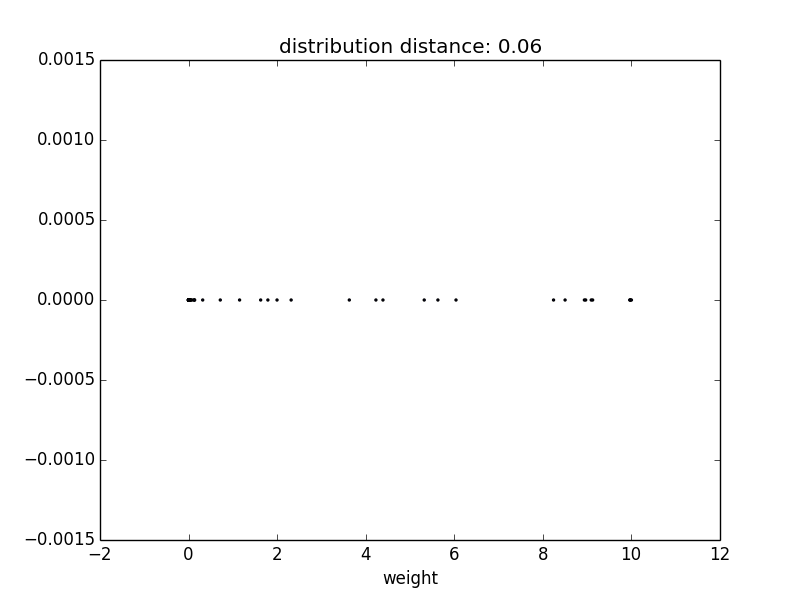

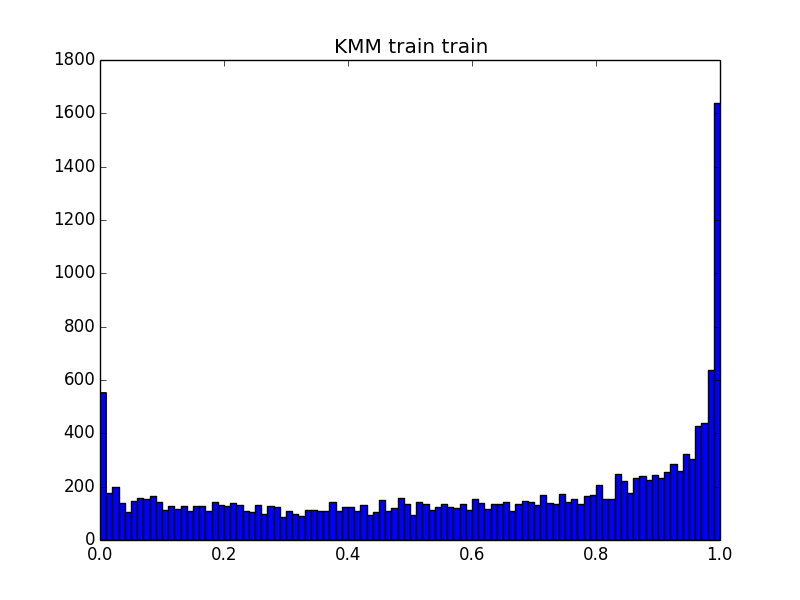

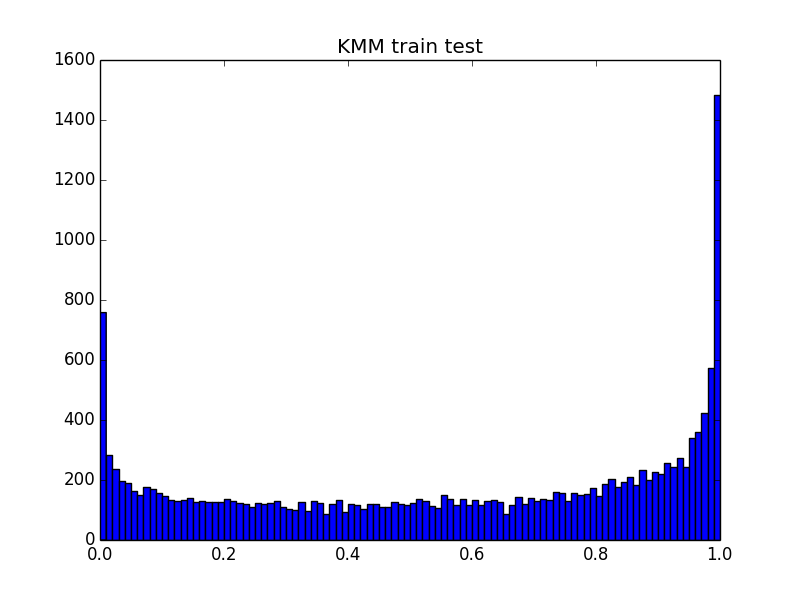

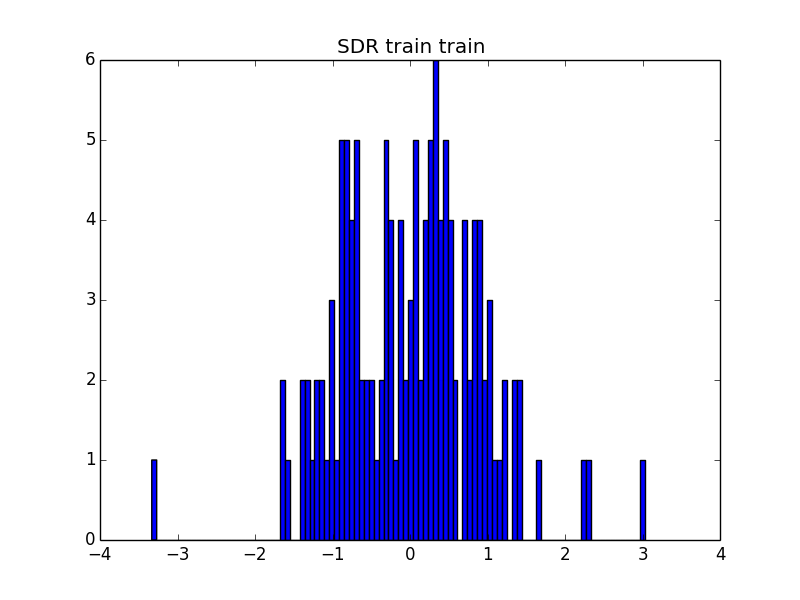

numerical gradient:
[[  75.31739486]
 [ 165.42921624]]
analytical gradient:
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 0.638350995911
L_args len: 2
num_tight: 0
solver error: 3.30872245021e-24
[[-0.79204306]
 [ 6.83060692]]


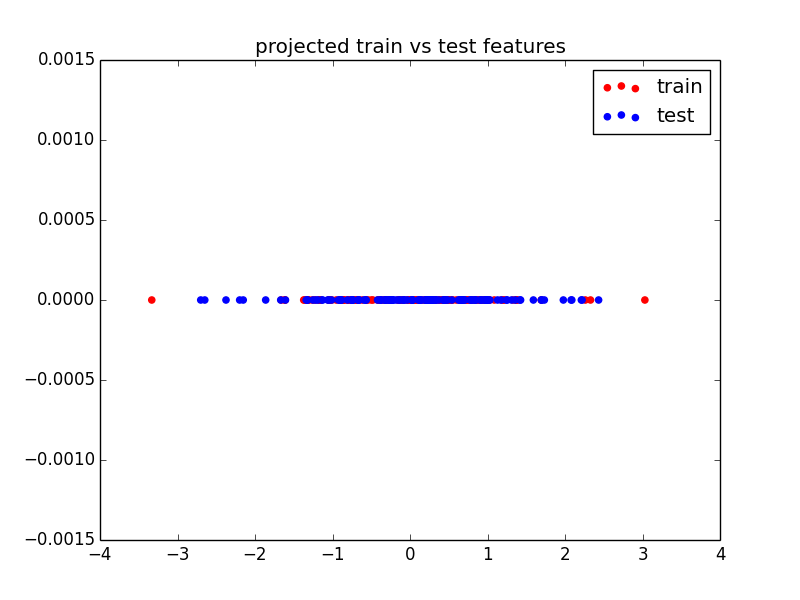

obj_val: 91.1144493068


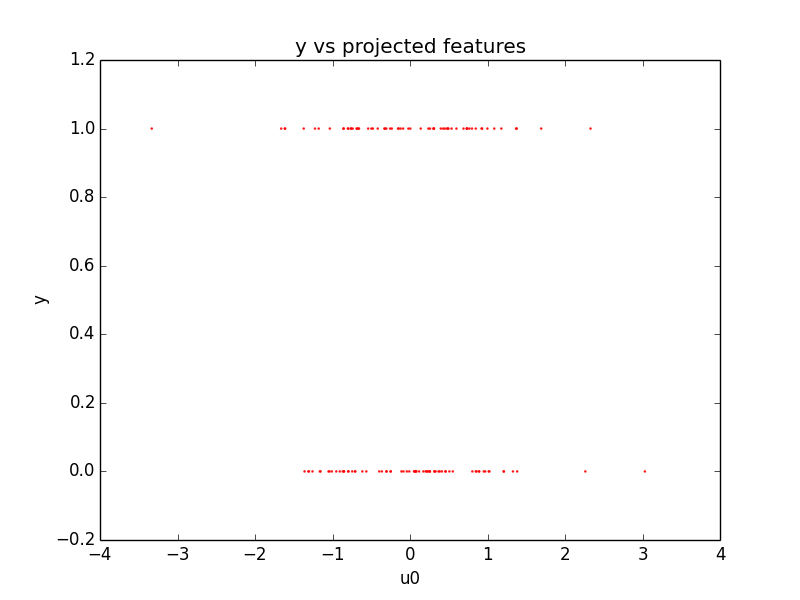

L_args len: 2
L_args len: 2
num_tight: 0
solver error: 1.05879118407e-22
num_tight: 0
solver error: 0.638405393659
L_args len: 2
num_tight: 0
solver error: 6.61744490042e-24
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 1.48402733512
L_args len: 2
num_tight: 0
solver error: 0.0
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 1.85042324545
L_args len: 2
num_tight: 0
solver error: 2.11758236814e-22
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 1.32348898008e-23
num_tight: 0
solver error: 1.66823594754
L_args len: 2
num_tight: 0
solver error: 4.23516473627e-22
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 3.30872245021e-24
num_tight: 0
solver error: 1.36056900513
L_args len: 2
num_tight: 0
solver error: 2.06795153138e-25
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 0.417982254948
L_args len: 2
num_tight: 0
solver error: 0.0
L_args len: 2
L_args len: 2
nu

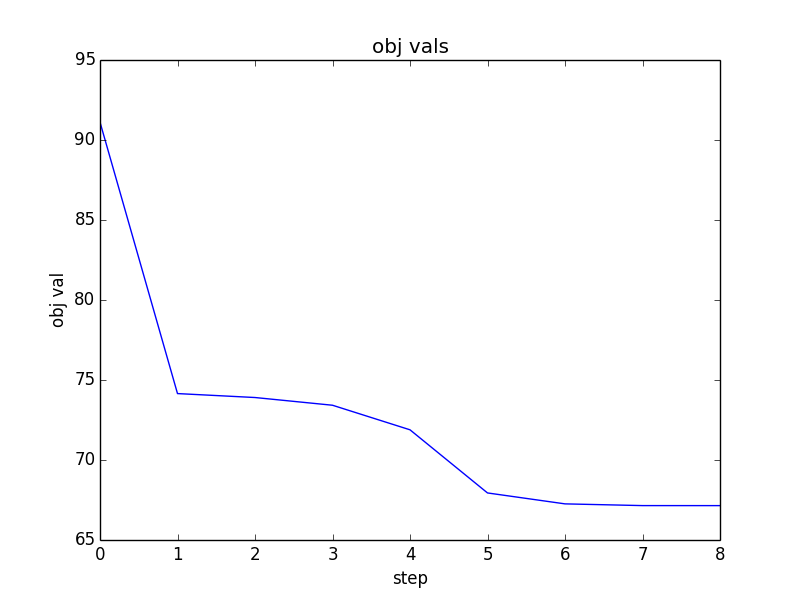

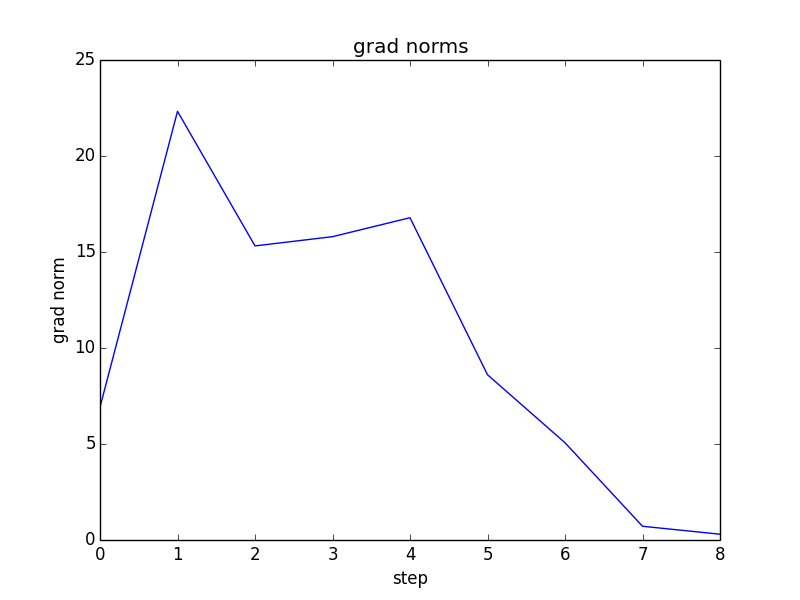

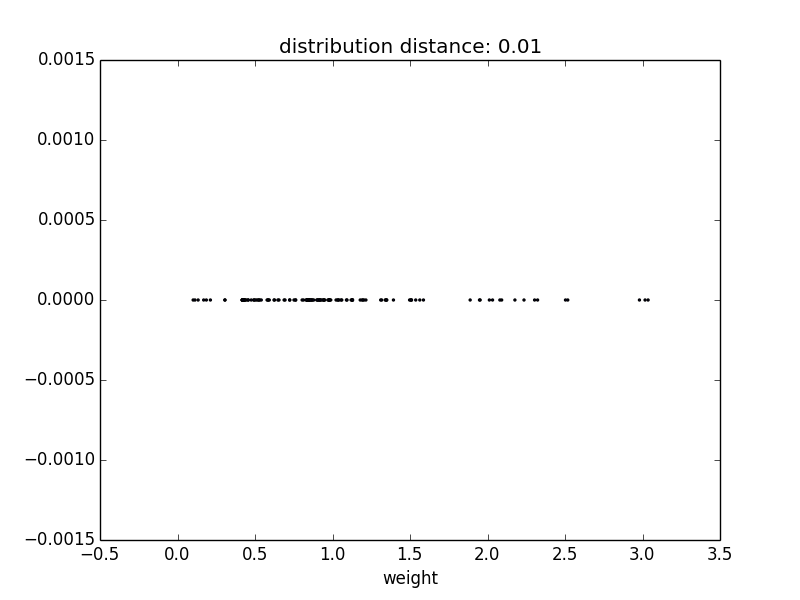

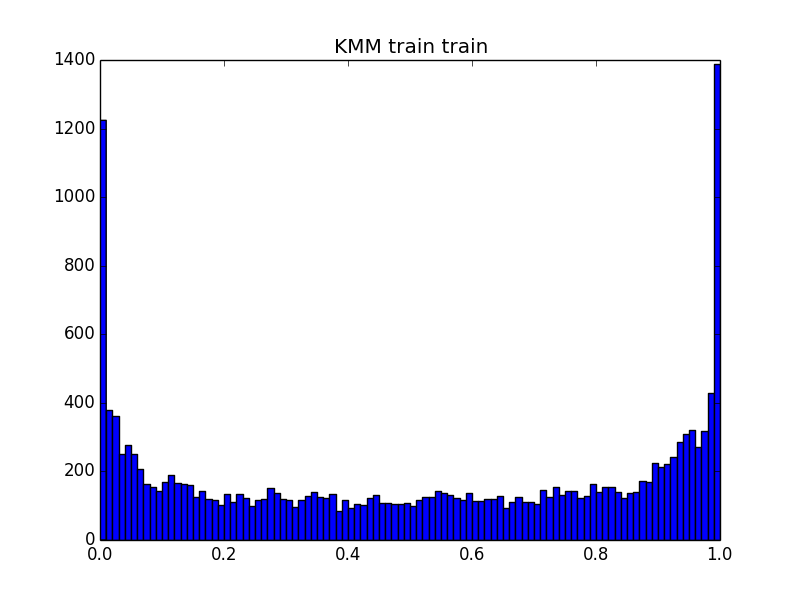

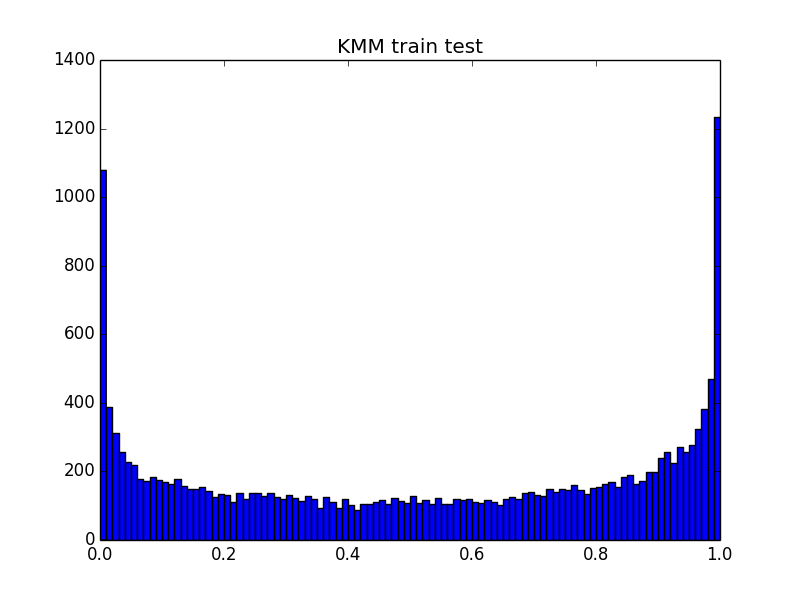

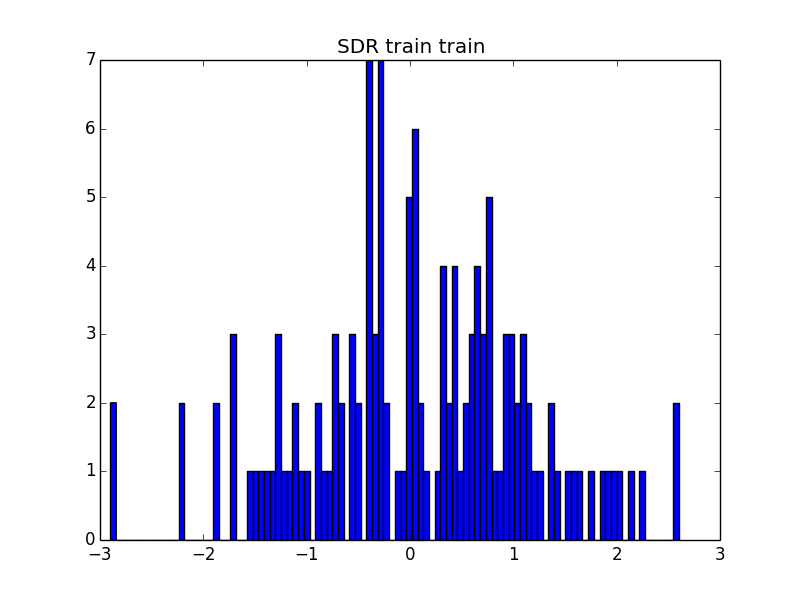

numerical gradient:
[[ -0.41775528]
 [ 16.81655463]]
analytical gradient:
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 2.11758236814e-22
num_tight: 0
solver error: 0.181052091408
L_args len: 2
num_tight: 0
solver error: 2.64697796017e-23
[[ -0.9211878 ]
 [ 16.35171611]]


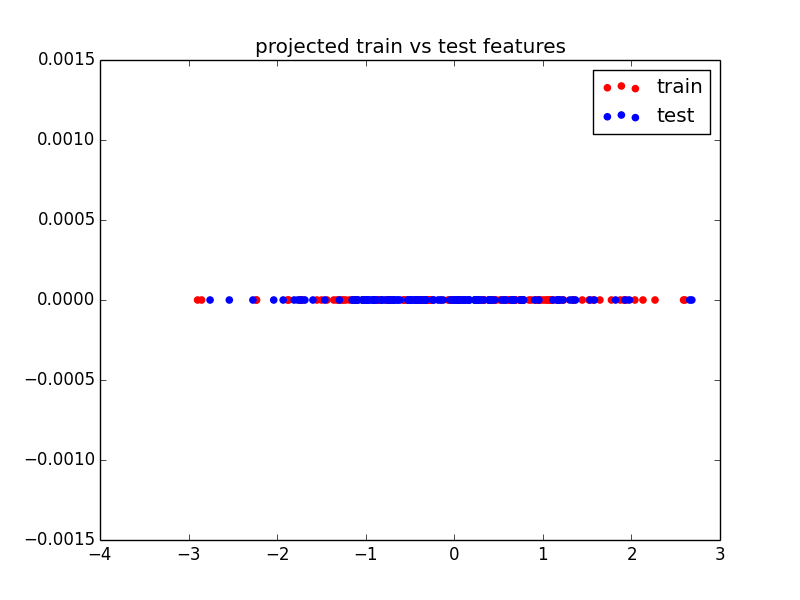

obj_val: 67.1487070569


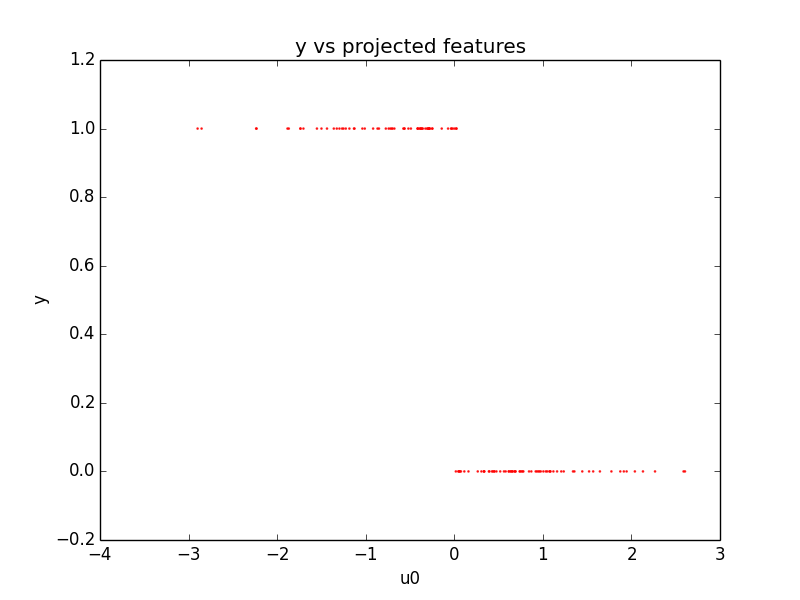

annealing step P: [[ 0.03790854]
 [-0.99928121]] 67.1487070569
plot_anneal


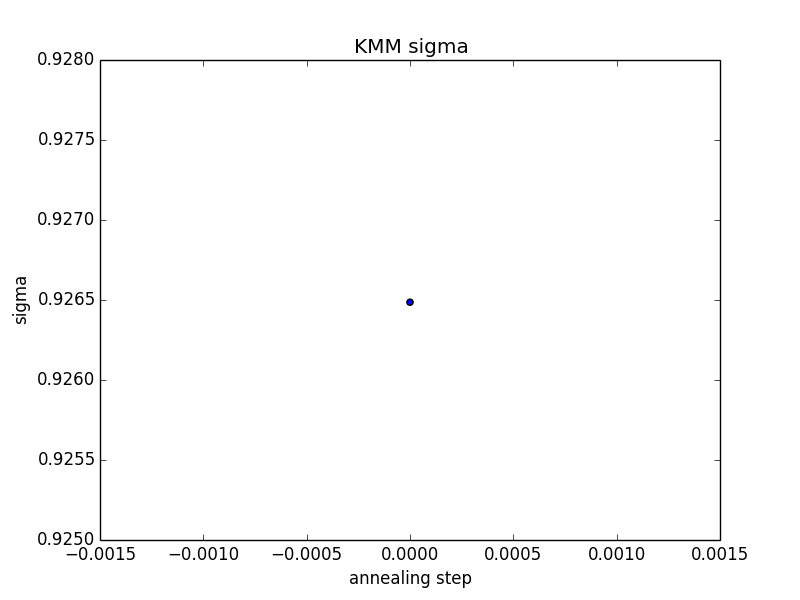

this anneal obj_val: 67.1487070569 P: [[ 0.03790854]
 [-0.99928121]]


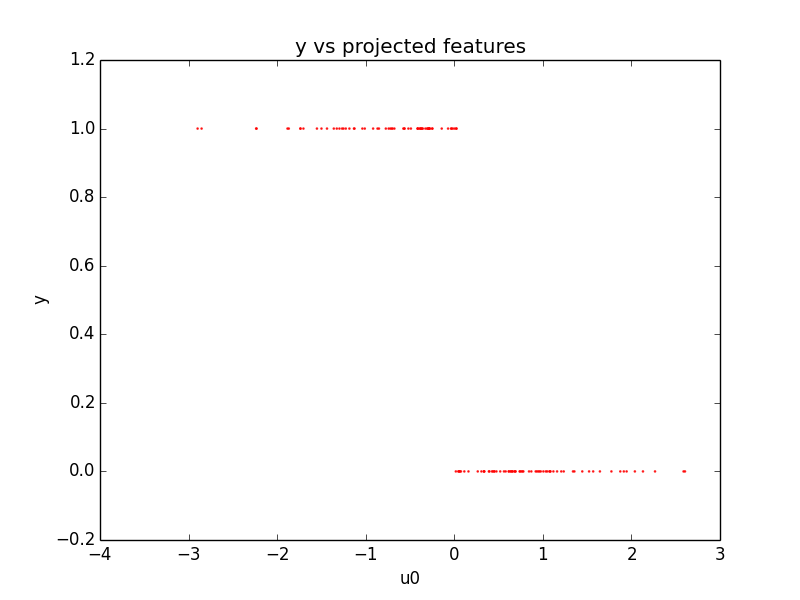

obj_vals [67.148707056864765]
plot_anneal_step_state


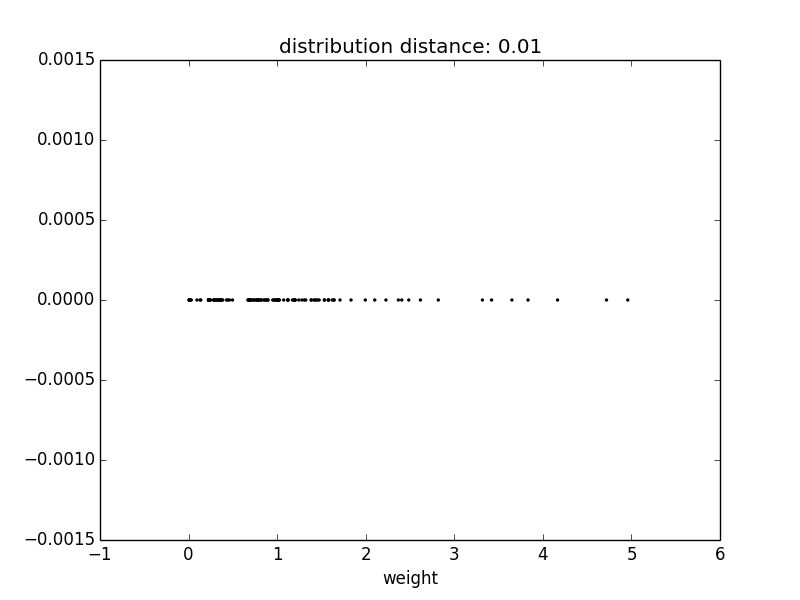

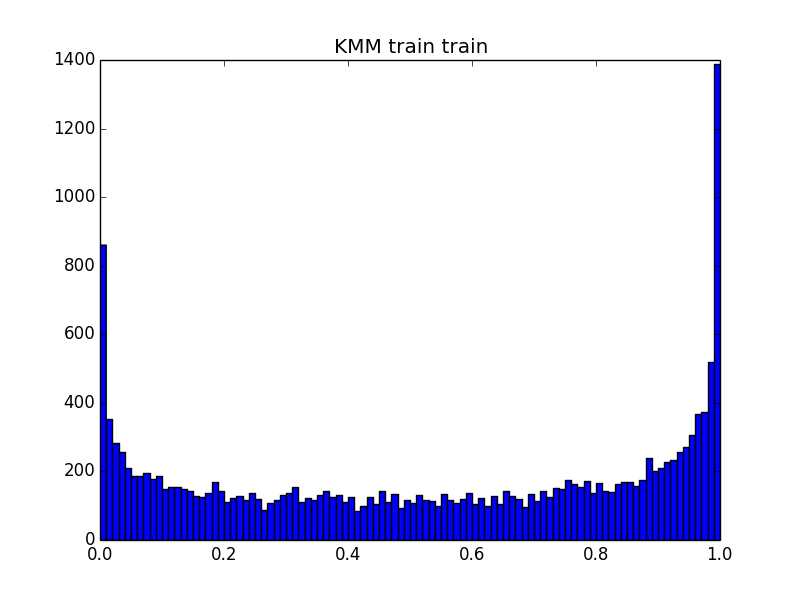

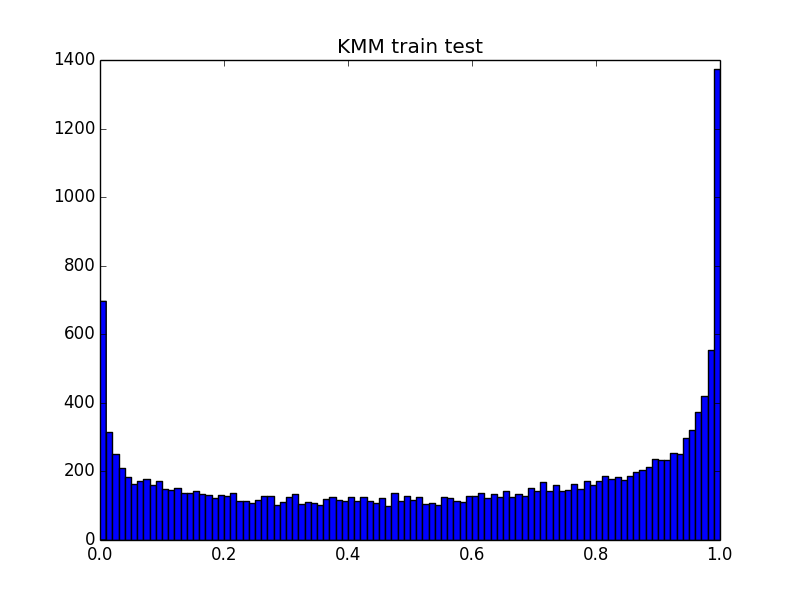

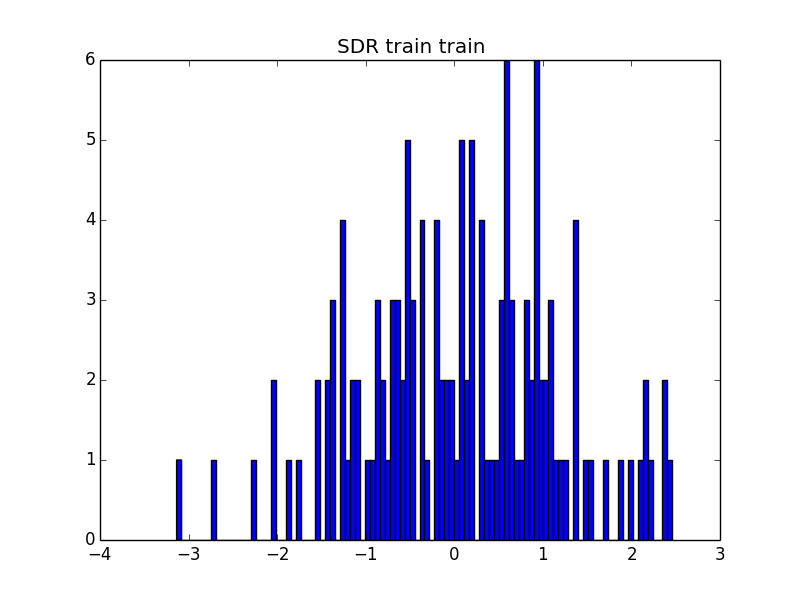

numerical gradient:
[[-545.96255459]
 [-466.31733862]]
analytical gradient:
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 1.32207404109
L_args len: 2
num_tight: 0
solver error: 1.05879118407e-22
[[ 11.38736346]
 [ 15.79553164]]


/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/pyplot.py:412: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_num_figures`).
  max_open_warning, RuntimeWarning)


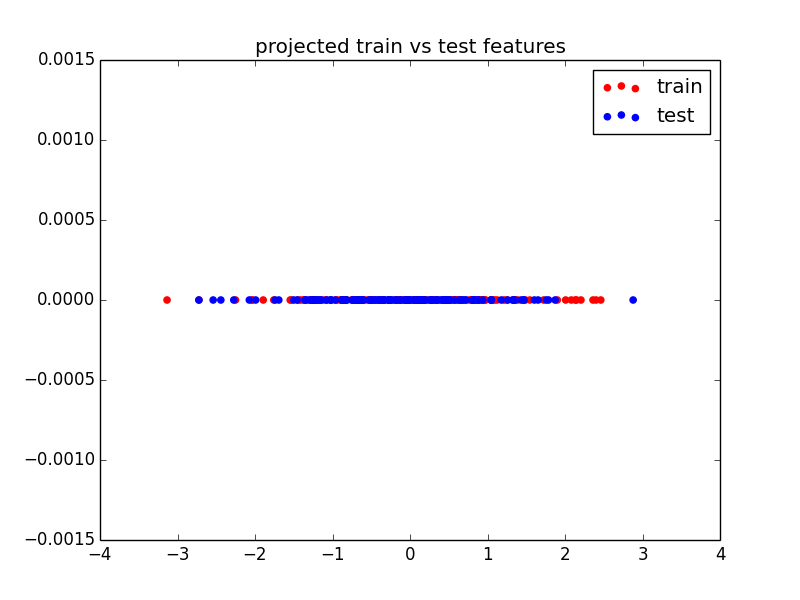

obj_val: 83.7182656758


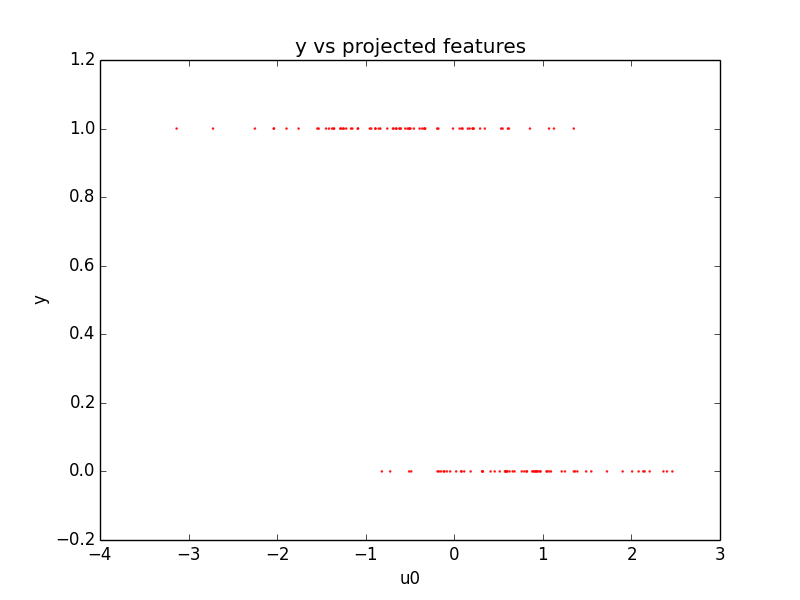

L_args len: 2
L_args len: 2
num_tight: 0
solver error: 2.06795153138e-25
num_tight: 0
solver error: 1.32207404178
L_args len: 2
num_tight: 0
solver error: 0.0
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 0.191672637686
L_args len: 2
num_tight: 0
solver error: 0.0
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 2.64697796017e-23
num_tight: 0
solver error: 0.178608665176
L_args len: 2
num_tight: 0
solver error: 1.05879118407e-22
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 1.05879118407e-22
num_tight: 0
solver error: 0.186077939267
L_args len: 2
num_tight: 0
solver error: 0.0
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 0.181267456701
L_args len: 2
num_tight: 0
solver error: 0.0
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 6.61744490042e-24
num_tight: 0
solver error: 0.177479524704
L_args len: 2
num_tight: 0
solver error: 5.29395592034e-23
L_args len: 2
L_args len: 2
num_tight: 0


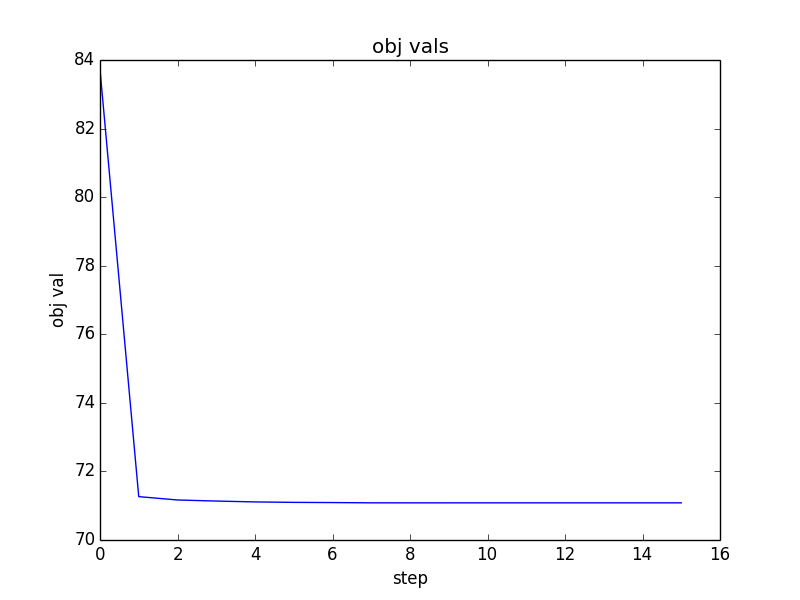

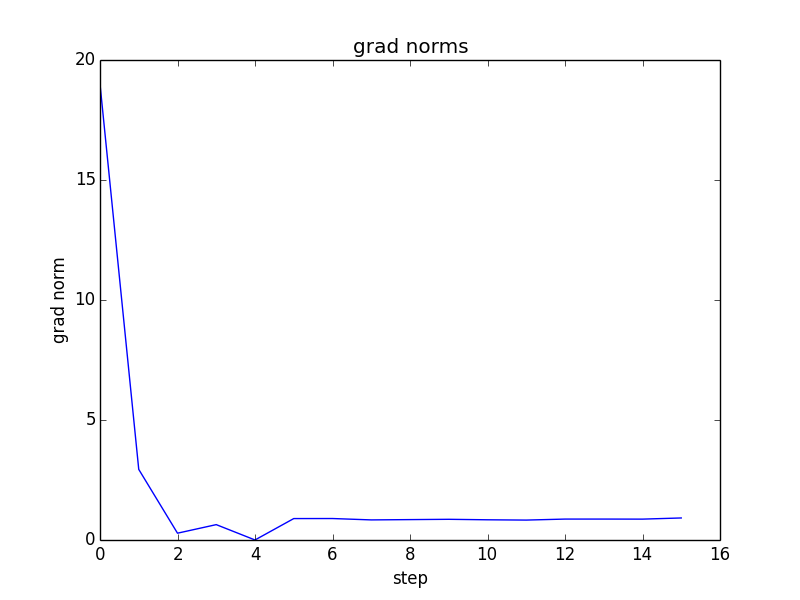

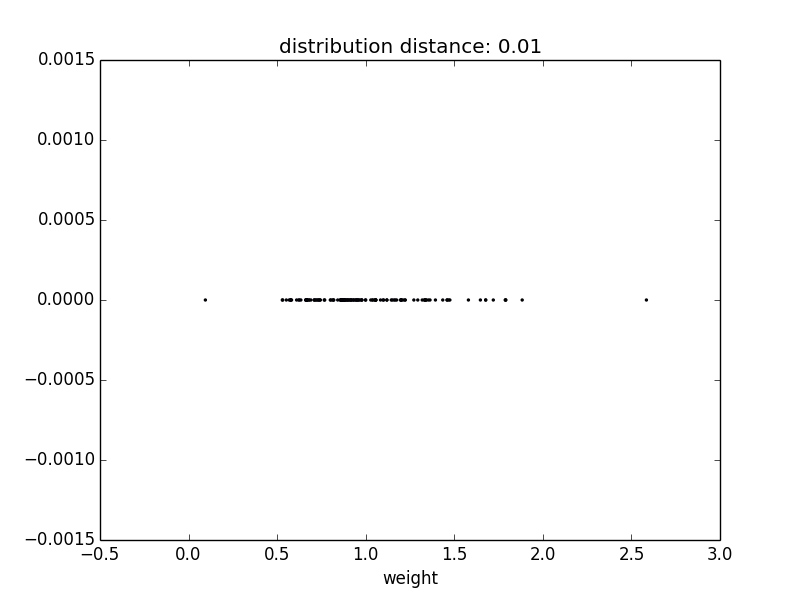

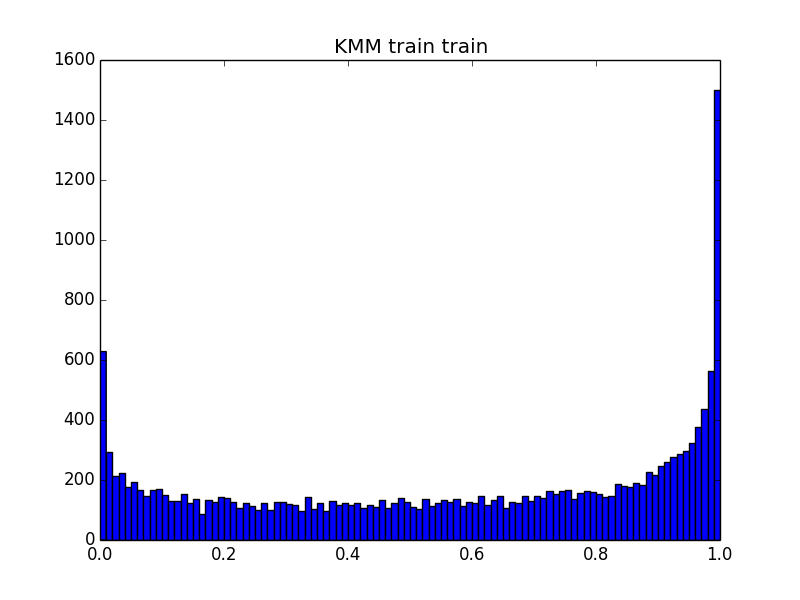

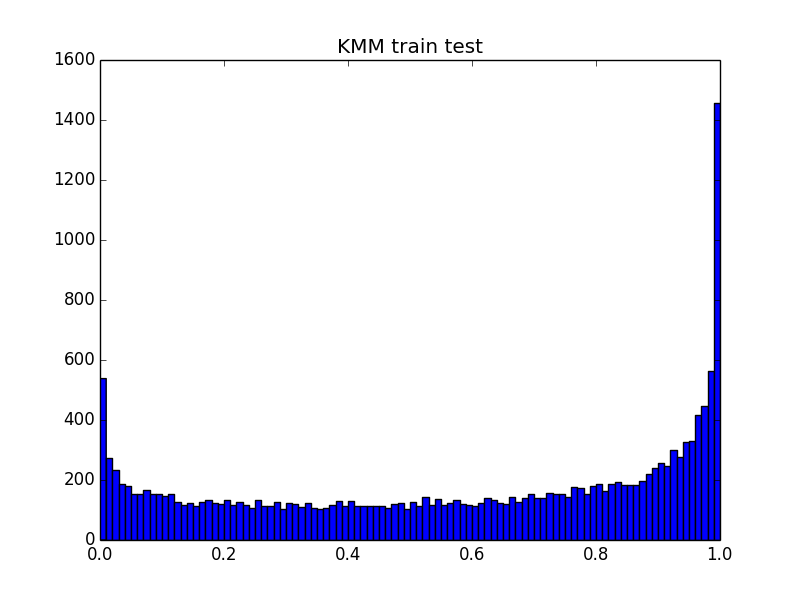

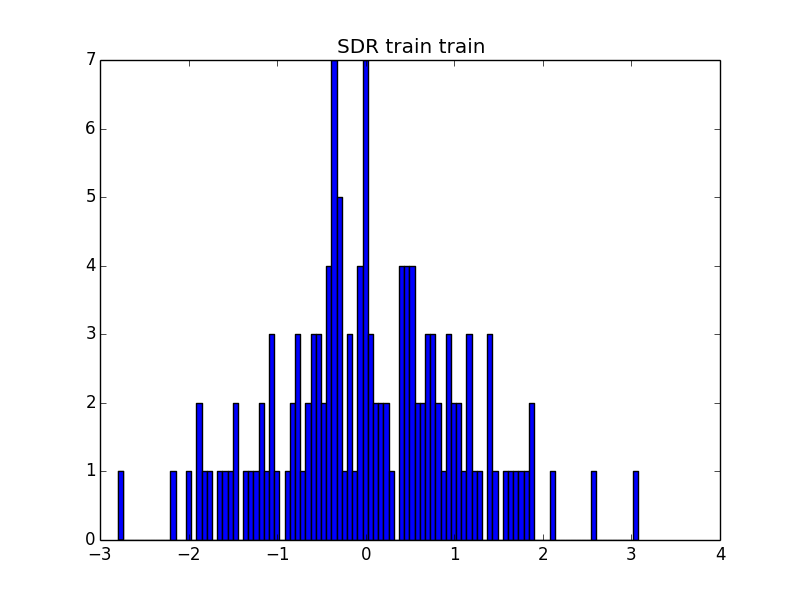

numerical gradient:
[[ 807.94667579]
 [  21.54323212]]
analytical gradient:
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 5.29395592034e-23
num_tight: 0
solver error: 0.177713952331
L_args len: 2
num_tight: 0
solver error: 8.47032947254e-22
[[ -0.79691791]
 [ 14.62908722]]


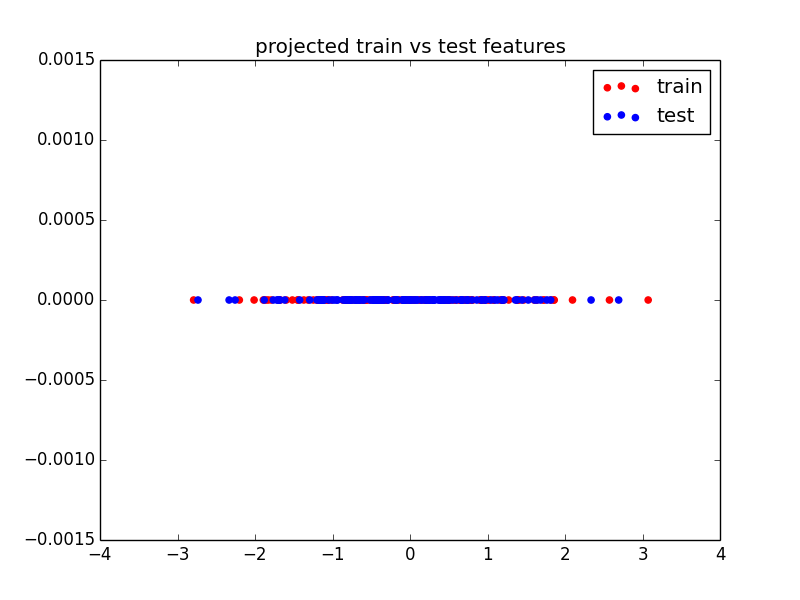

obj_val: 71.083729851


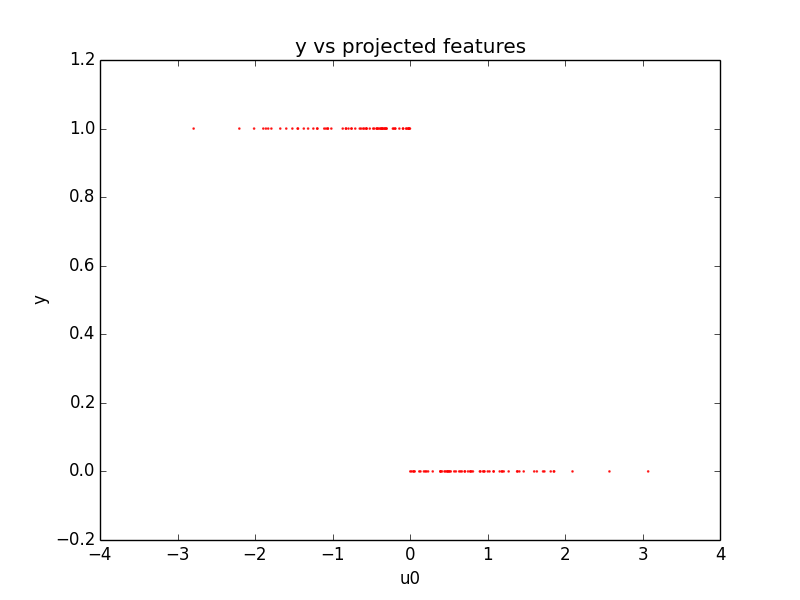

annealing step P: [[-0.0022555 ]
 [-0.99999746]] 71.083729851
plot_anneal


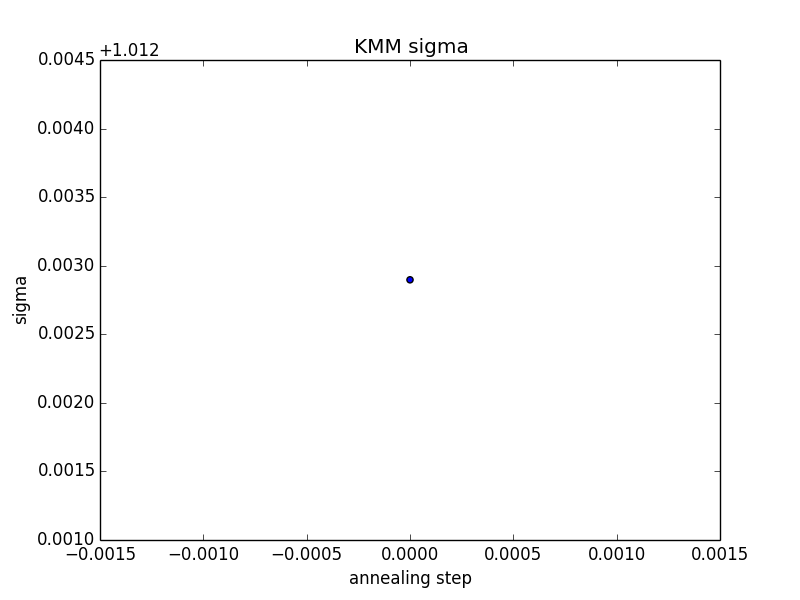

this anneal obj_val: 71.083729851 P: [[-0.0022555 ]
 [-0.99999746]]


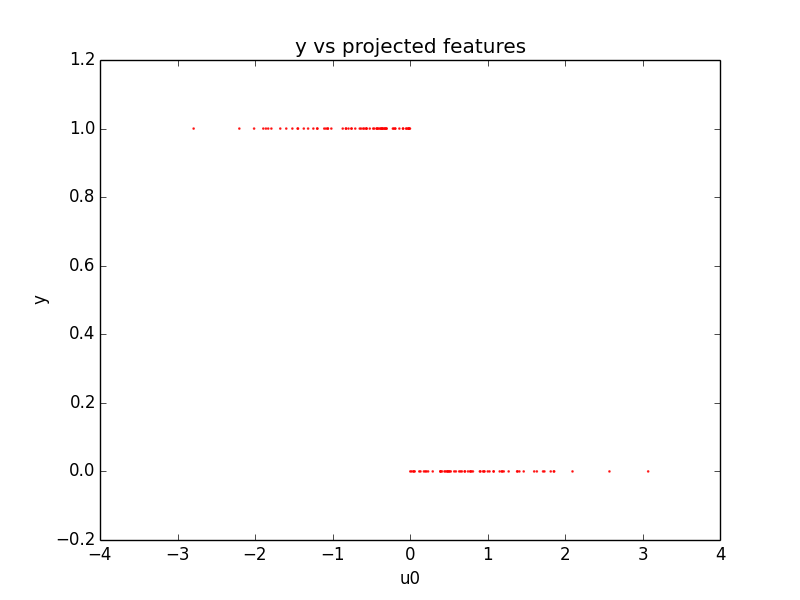

obj_vals [71.083729851041497]
plot_anneal_step_state


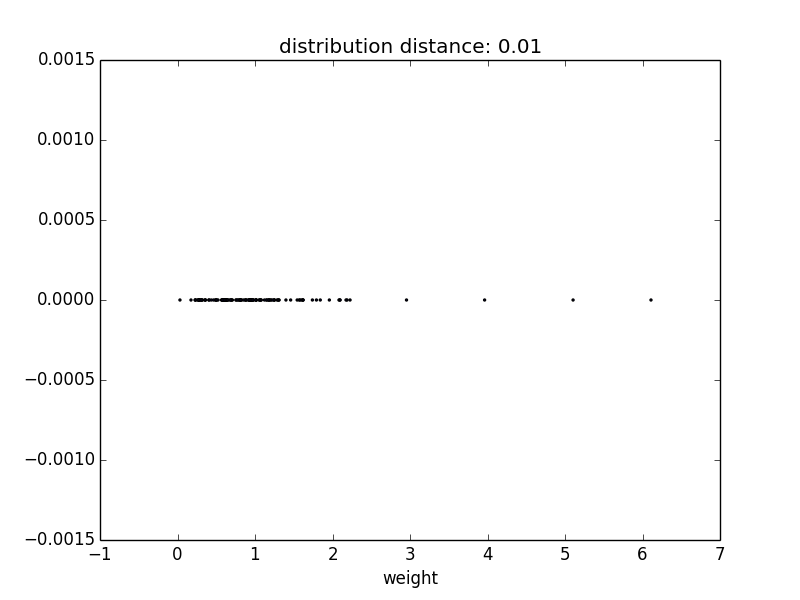

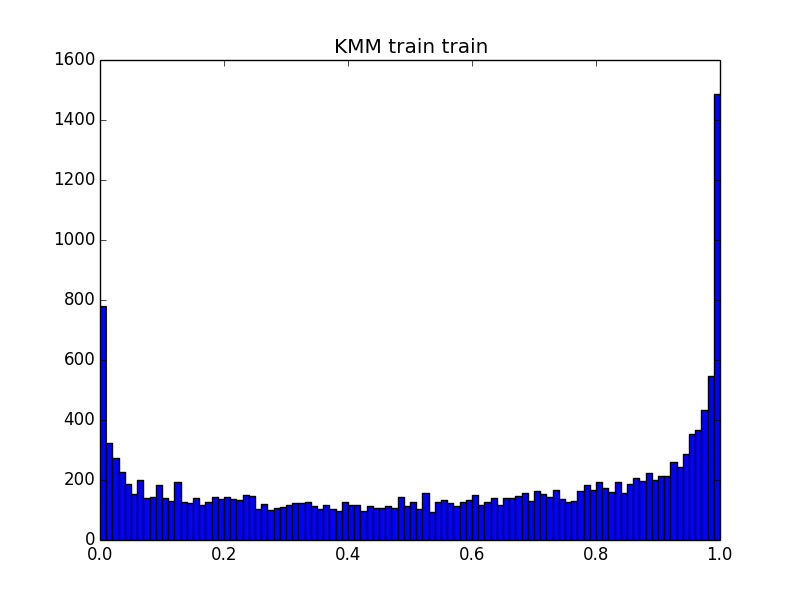

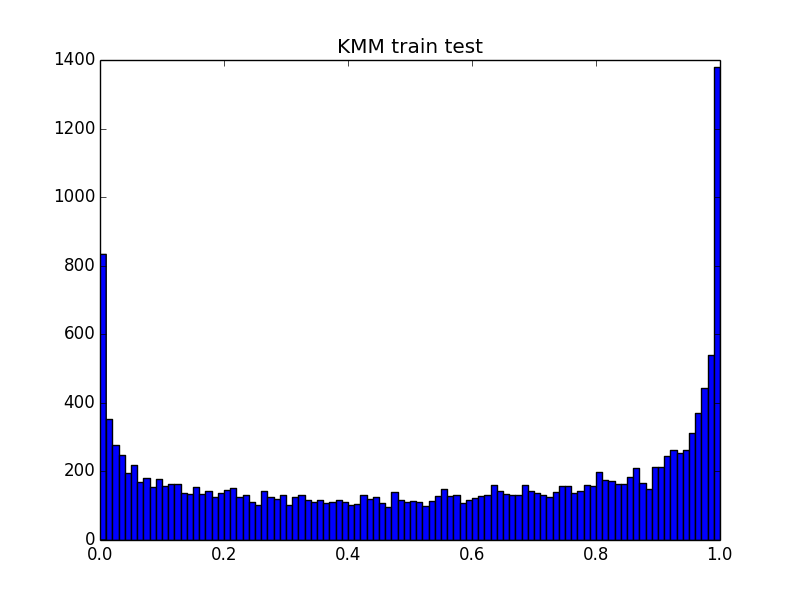

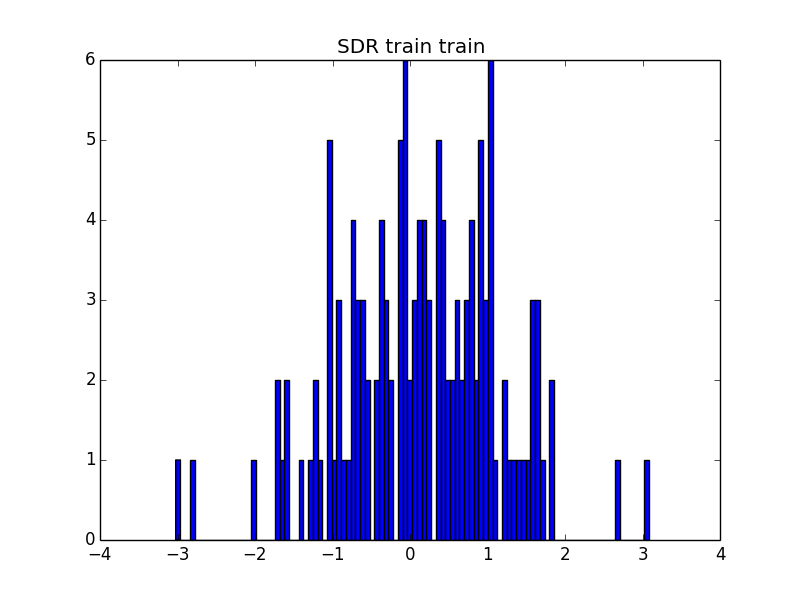

numerical gradient:
[[ -1.18951105]
 [-21.4529183 ]]
analytical gradient:
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 0.730728304022
L_args len: 2
num_tight: 0
solver error: 2.64697796017e-23
[[ -0.15397069]
 [-13.04237856]]


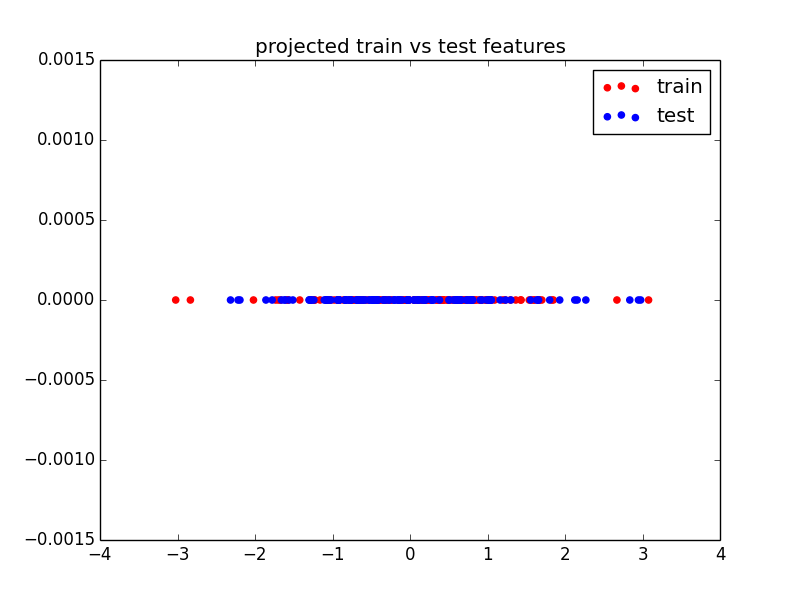

obj_val: 91.9762911737


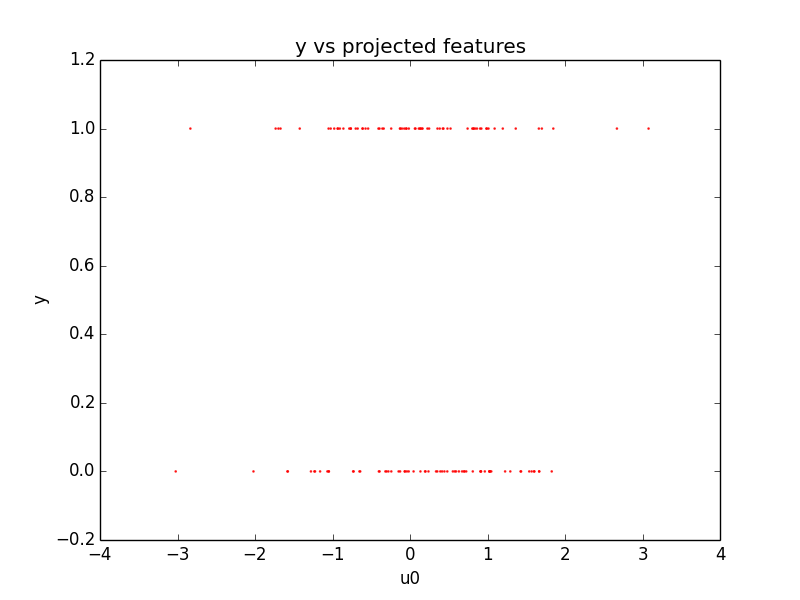

L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 0.730752664044
L_args len: 2
num_tight: 0
solver error: 1.05879118407e-22
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 1.21971154475
L_args len: 2
num_tight: 0
solver error: 2.64697796017e-23
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 0.239654638063
L_args len: 2
num_tight: 0
solver error: 0.0
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 1.65436122511e-24
num_tight: 0
solver error: 0.18566442019
L_args len: 2
num_tight: 0
solver error: 0.0
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 3.30872245021e-24
num_tight: 0
solver error: 0.204949945473
L_args len: 2
num_tight: 0
solver error: 4.23516473627e-22
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 0.203715850551
L_args len: 2
num_tight: 0
solver error: 0.0
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0

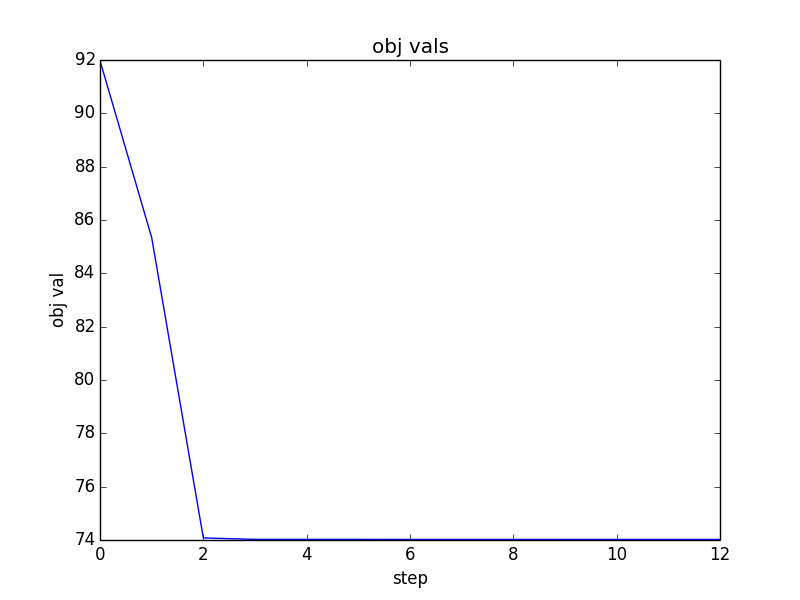

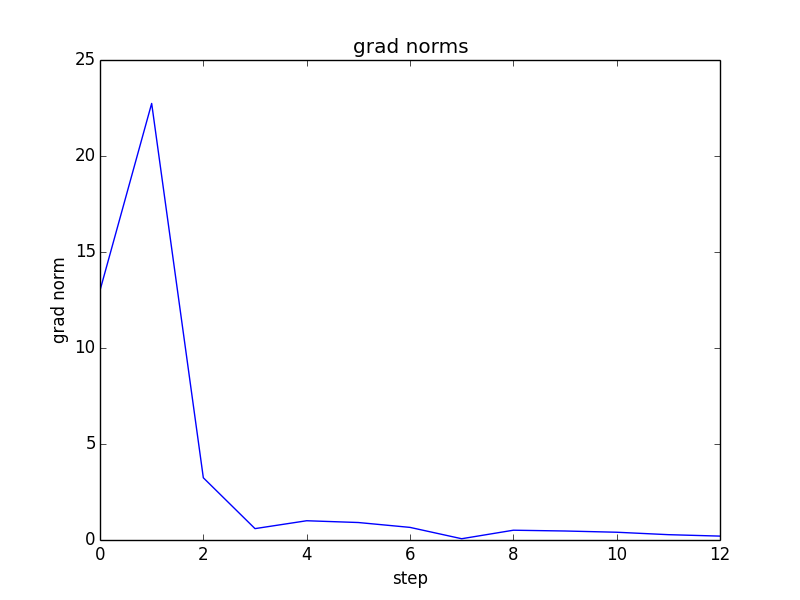

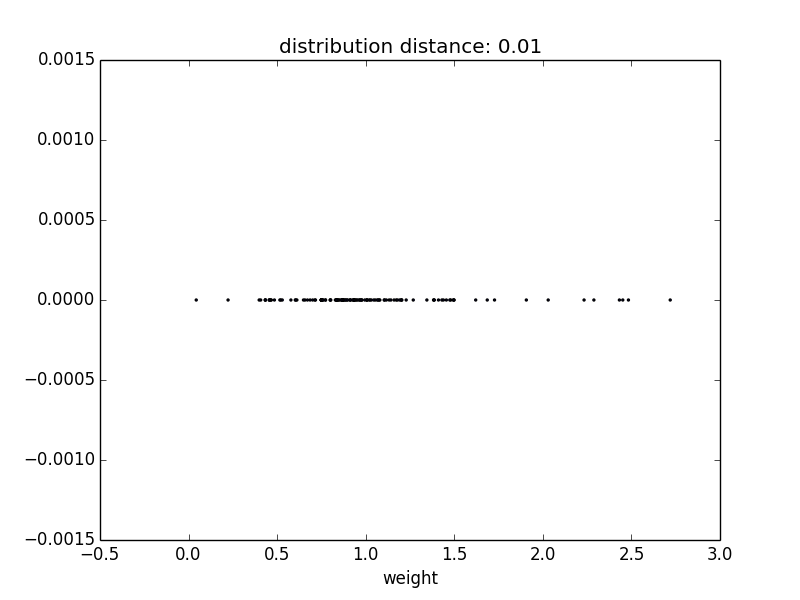

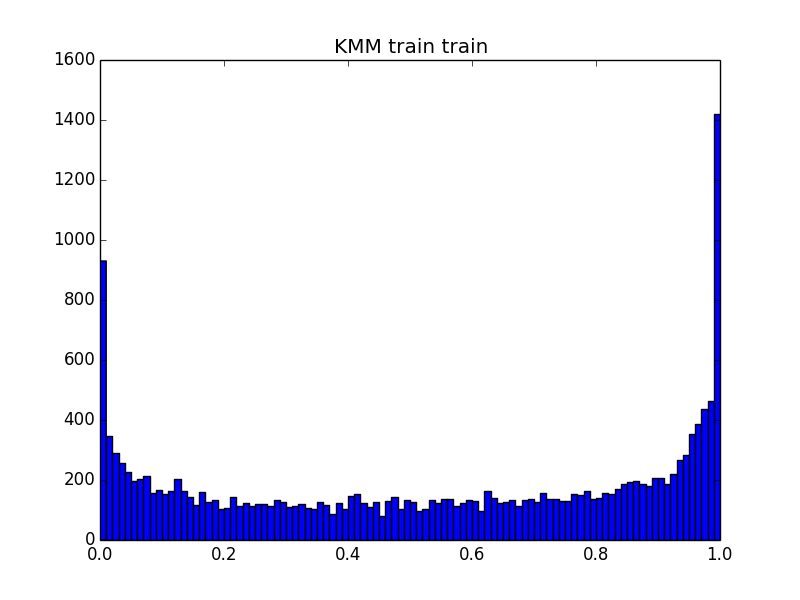

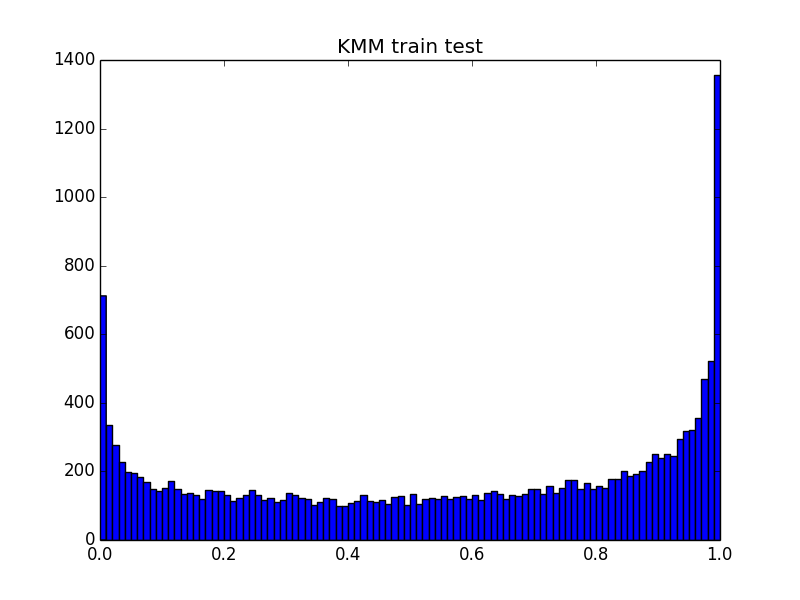

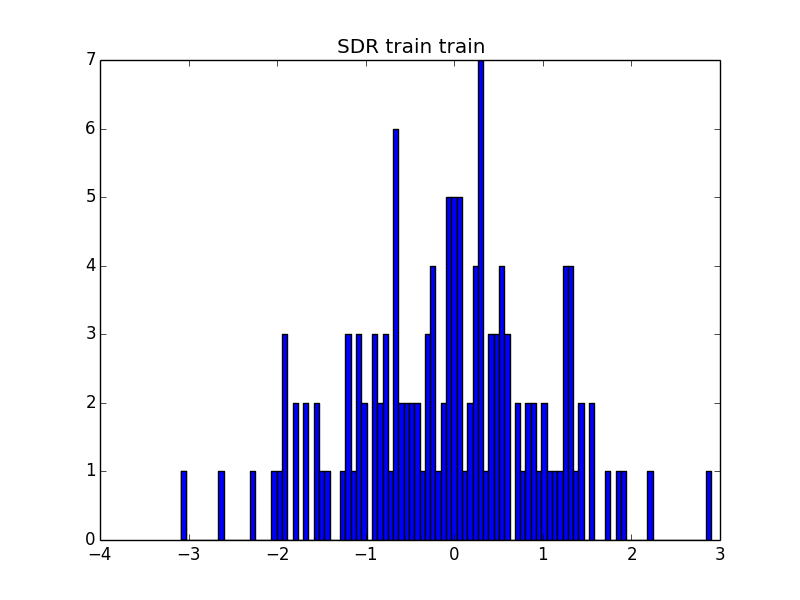

numerical gradient:
[[  0.75603595]
 [-14.4505737 ]]
analytical gradient:
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 2.64697796017e-23
num_tight: 0
solver error: 0.194695240864
L_args len: 2
num_tight: 0
solver error: 0.0
[[  0.49657307]
 [-13.86059211]]


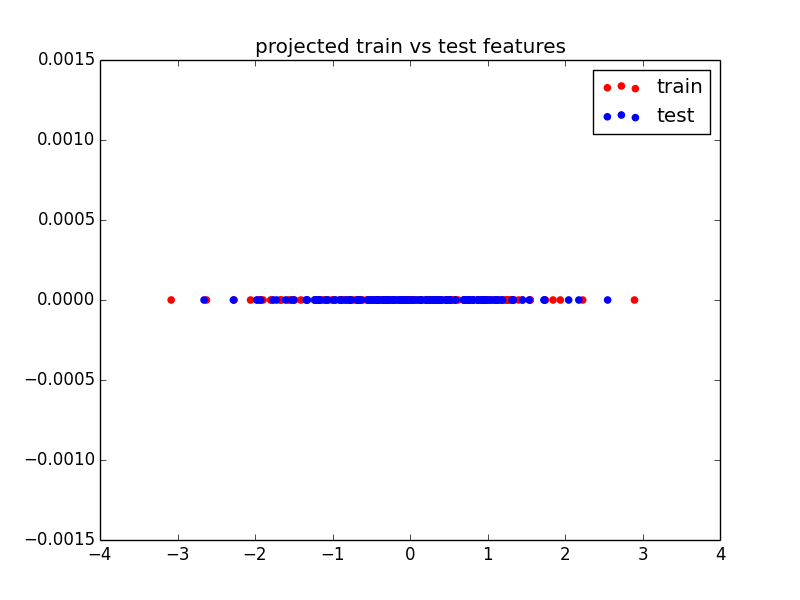

obj_val: 74.0198314414


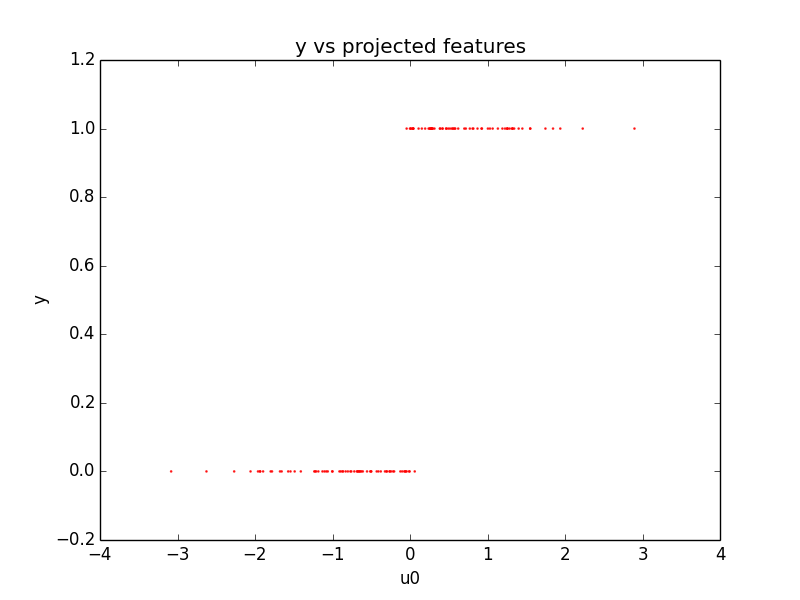

annealing step P: [[-0.05013742]
 [ 0.99874233]] 74.0198314414
plot_anneal


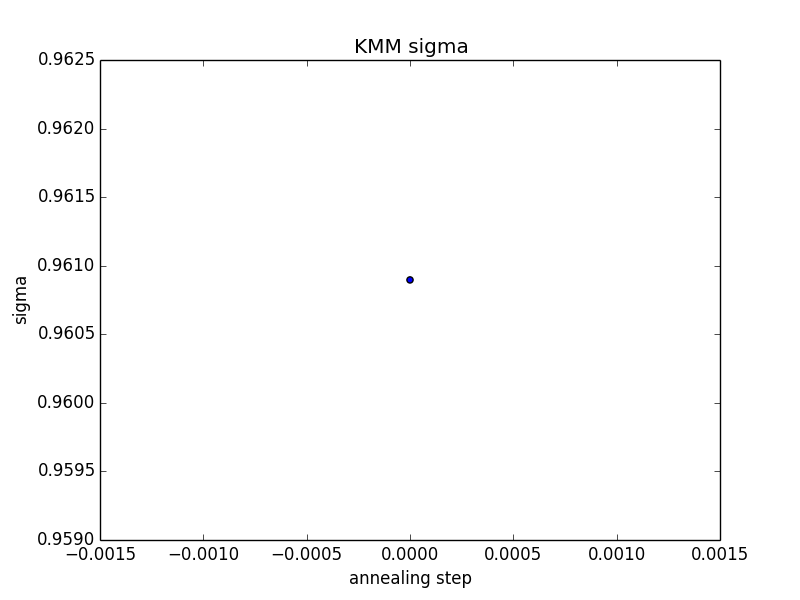

this anneal obj_val: 74.0198314414 P: [[-0.05013742]
 [ 0.99874233]]


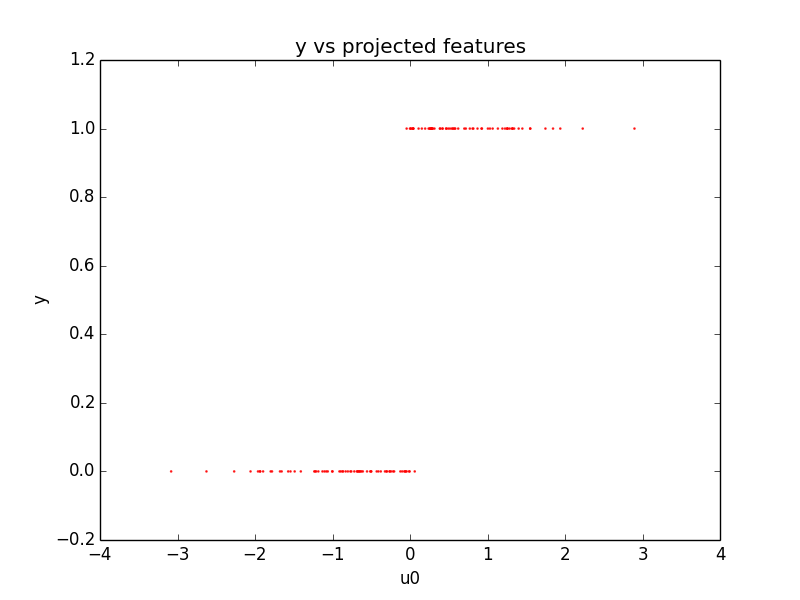

obj_vals [74.019831441395255]
plot_anneal_step_state


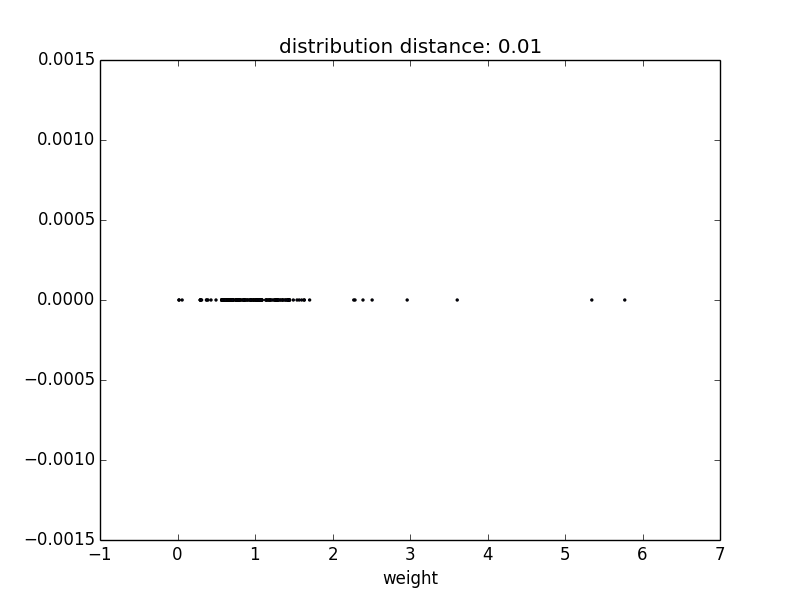

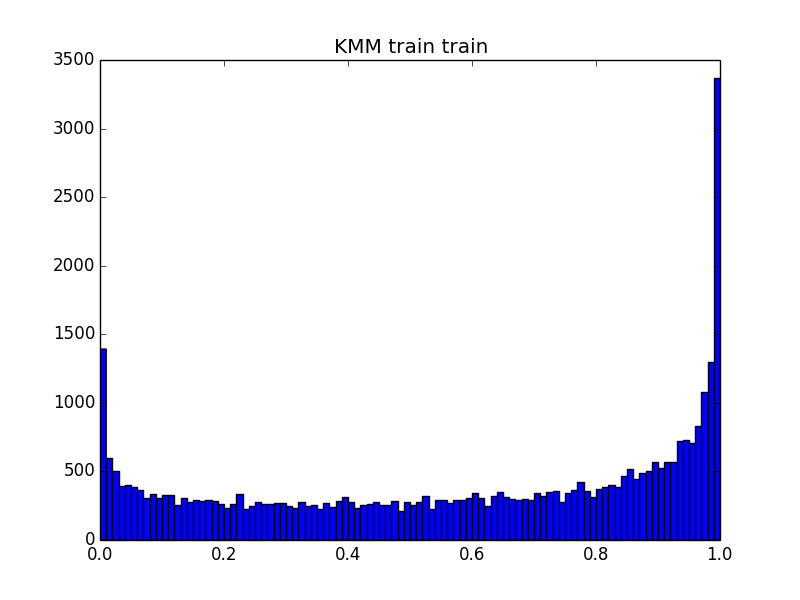

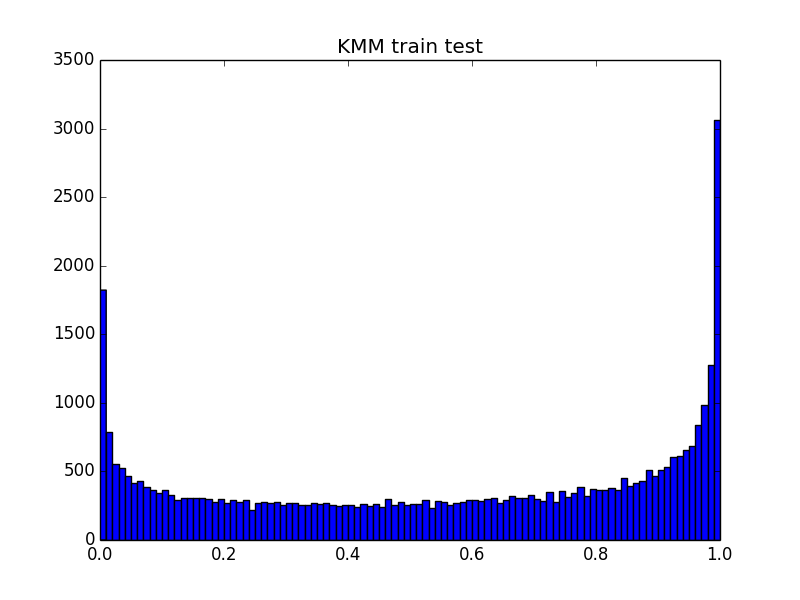

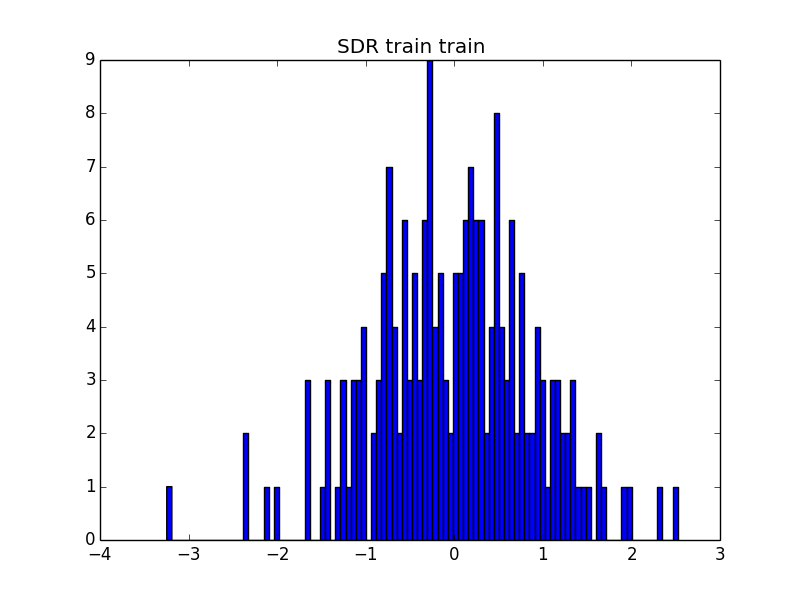

numerical gradient:
[[-15.9399156 ]
 [ 34.94505613]]
analytical gradient:
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 4.23516473627e-22
num_tight: 0
solver error: 2.16538134986
L_args len: 2
num_tight: 0
solver error: 0.0
[[-23.21116457]
 [ 32.54196291]]


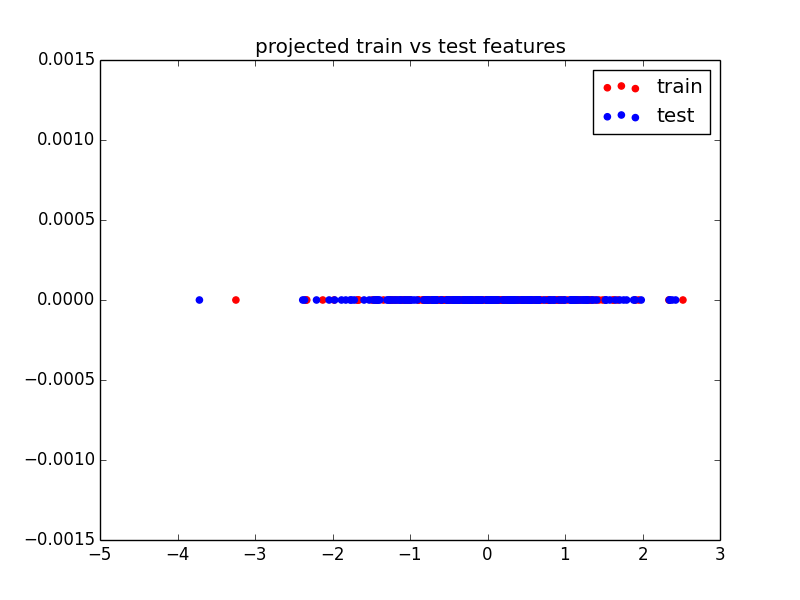

obj_val: 125.267648501


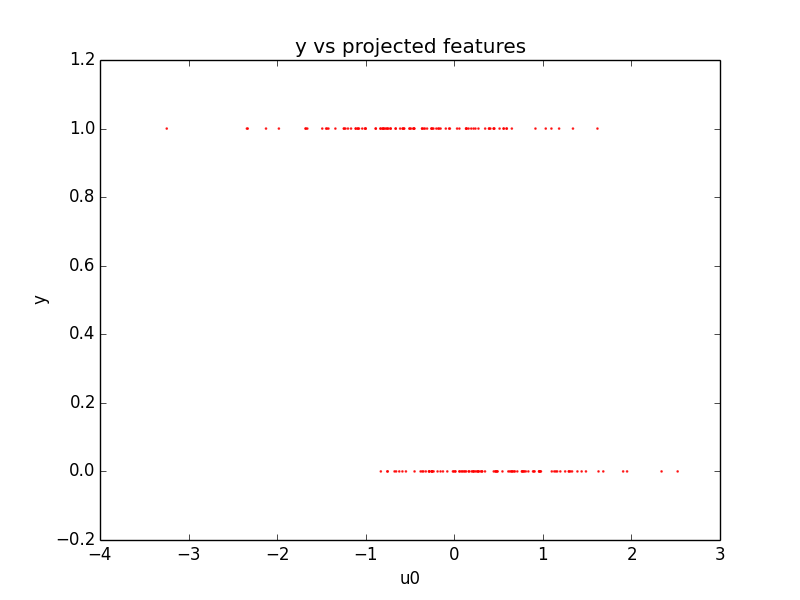

L_args len: 2
L_args len: 2
num_tight: 0
solver error: 2.64697796017e-23
num_tight: 0
solver error: 2.16535585475
L_args len: 2
num_tight: 0
solver error: 1.03397576569e-25
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 3.30872245021e-24
num_tight: 0
solver error: 0.262857331027
L_args len: 2
num_tight: 0
solver error: 0.0
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 0.0
num_tight: 0
solver error: 0.25225812399
L_args len: 2
num_tight: 0
solver error: 0.0
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 1.32348898008e-23
num_tight: 0
solver error: 0.253030323324
L_args len: 2
num_tight: 0
solver error: 0.0
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 1.69406589451e-21
num_tight: 0
solver error: 0.254518346041
L_args len: 2
num_tight: 0
solver error: 8.47032947254e-22
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 3.30872245021e-24
num_tight: 0
solver error: 0.255056806867
L_args len: 2
num_tight: 0
solver error: 1.65436122511e-24
L_args len: 2


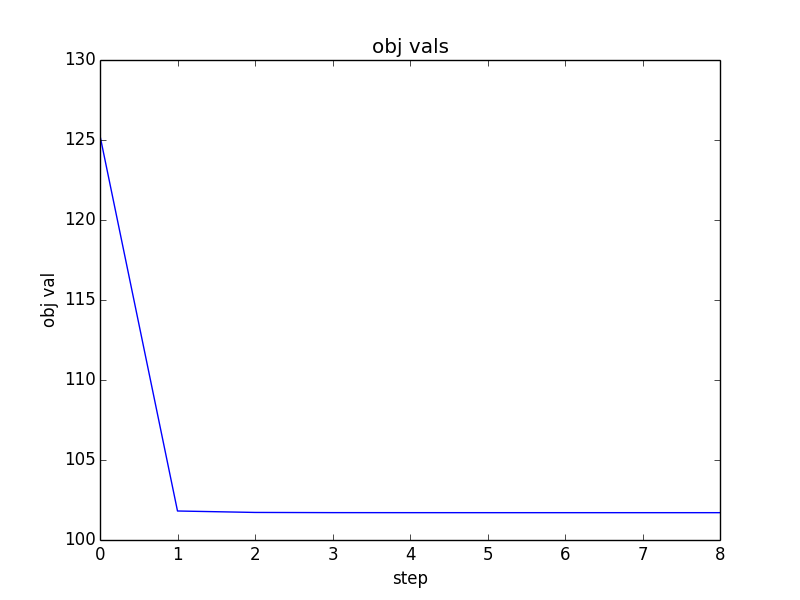

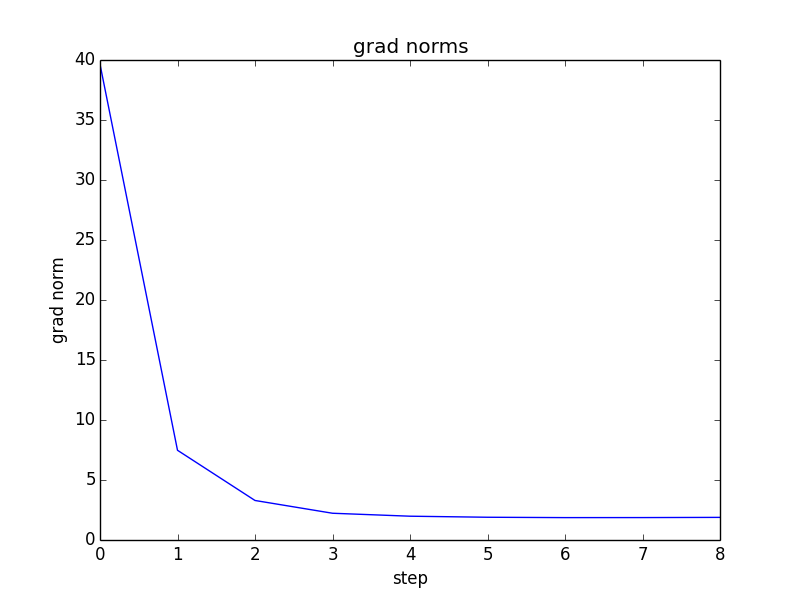

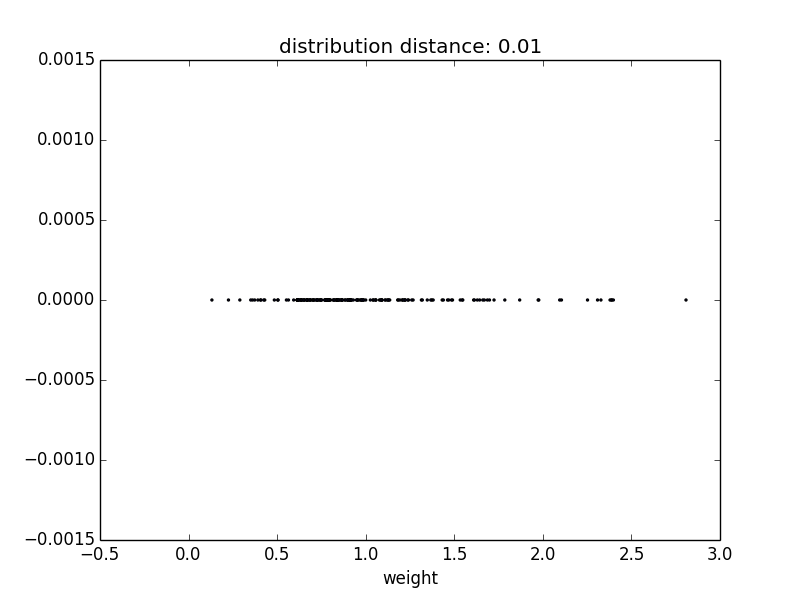

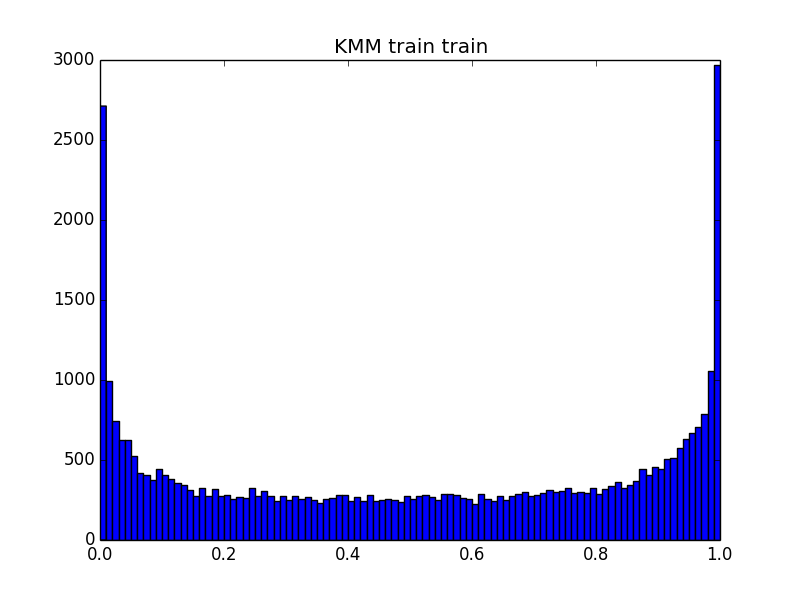

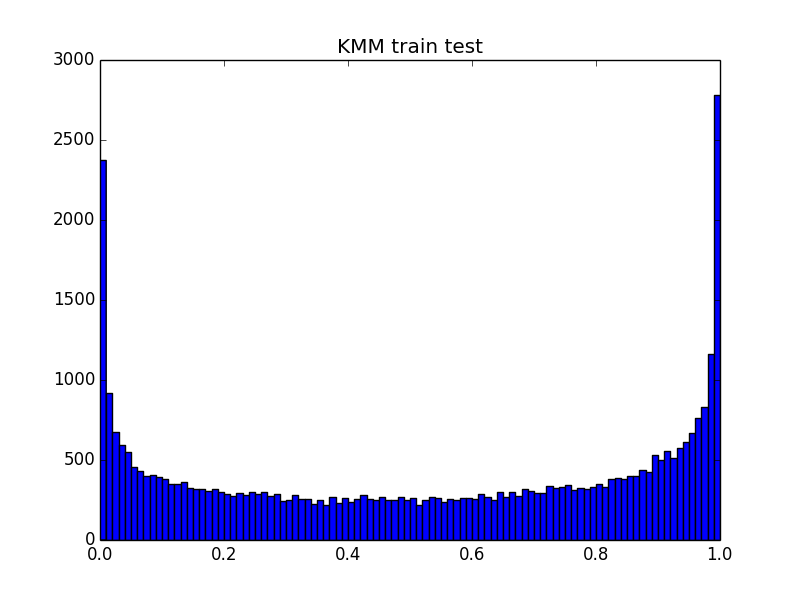

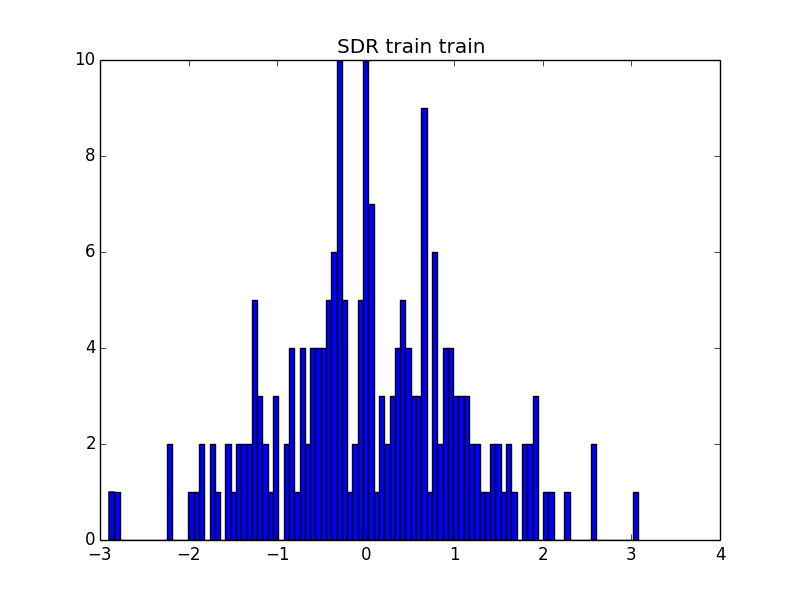

numerical gradient:
[[  2.90724268]
 [ 20.97751988]]
analytical gradient:
L_args len: 2
L_args len: 2
num_tight: 0
solver error: 6.61744490042e-24
num_tight: 0
solver error: 0.256249655801
L_args len: 2
num_tight: 0
solver error: 0.0
[[ -2.39158521]
 [ 21.55266891]]


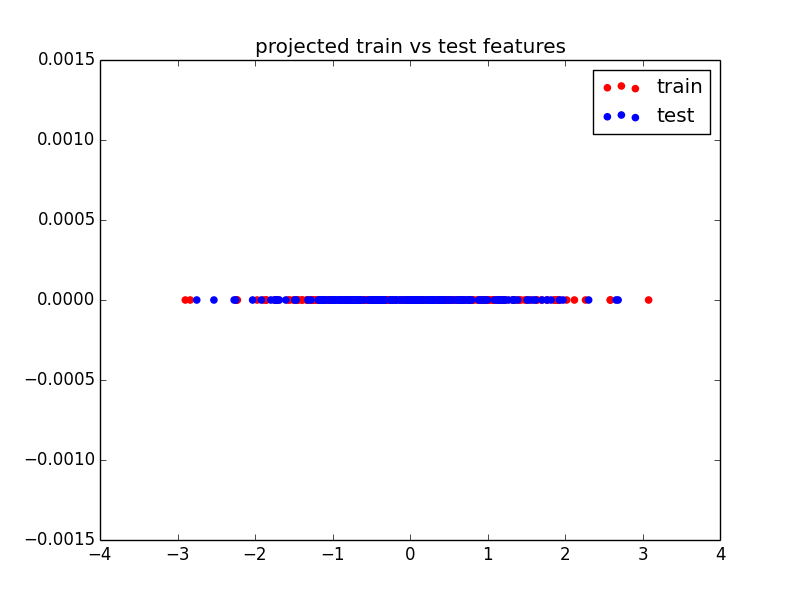

obj_val: 101.707955613


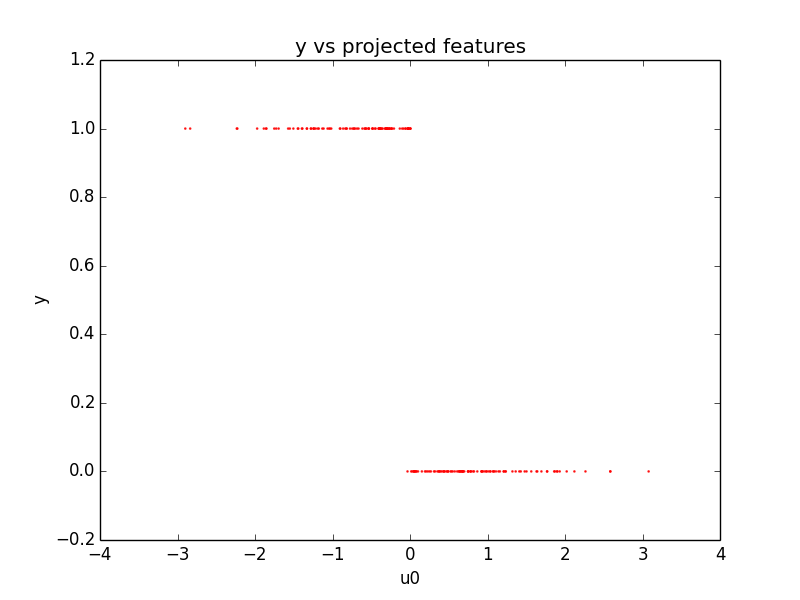

annealing step P: [[ 0.02671528]
 [-0.99964308]] 101.707955613
plot_anneal


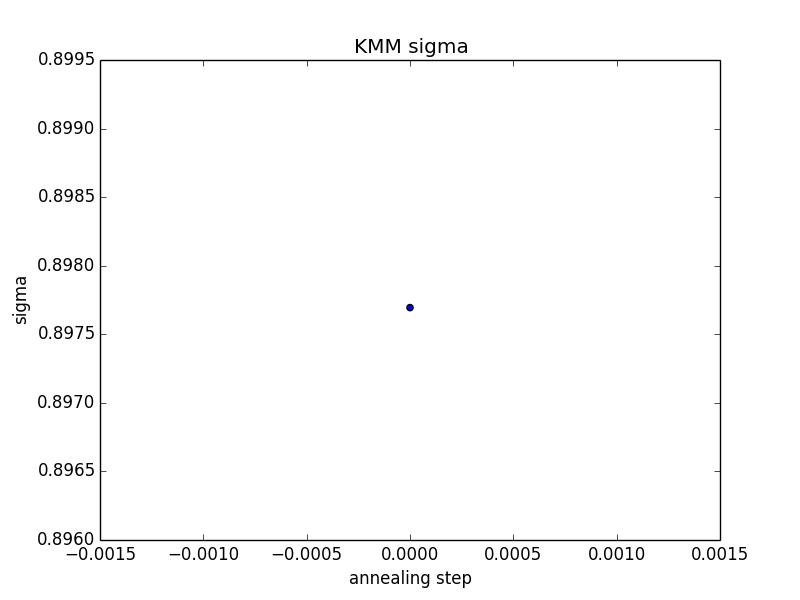

this anneal obj_val: 101.707955613 P: [[ 0.02671528]
 [-0.99964308]]


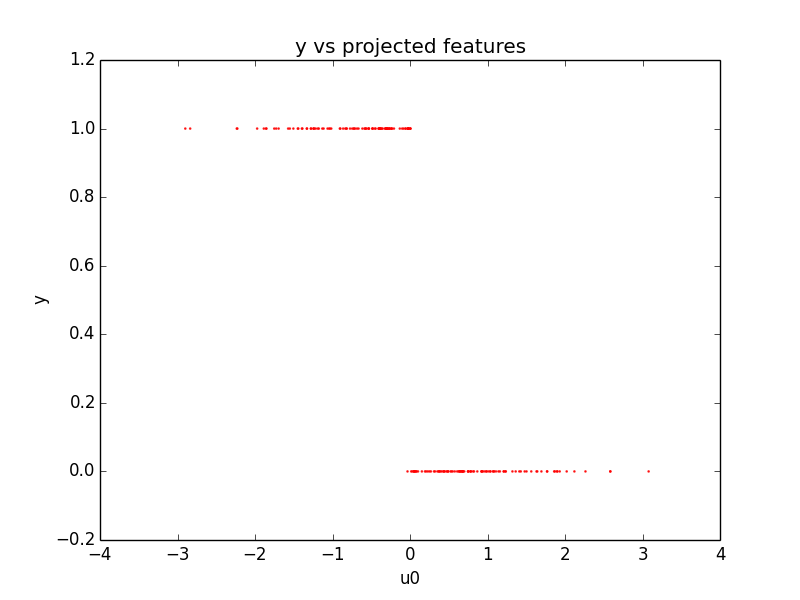

obj_vals [101.70795561347285]


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('projection_estimator', <domain_adapt.domain_adapt.kernels.projection_estimator object at 0x1058a3710>), ('weighted_estimator', <domain_adapt.domain_adapt.kernels.weighted_estimator object at 0x1058a3310>)]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'weighted_estimator': [<domain_adapt.domain_adapt.kernels.weighted_estimator object at 0x112b9c890>], 'projection_estimator__horse': [<functools.partial object at 0x112b9a100>]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=<functools.partial object at 0x10ad92890>, verbose=0)

In [7]:
# train cv
shift_X, shift_y = kernels.matrices_to_shift_Xy(xs_train, xs_test, ys_train, ys_test)
cv_estimator.fit(shift_X, shift_y)

In [8]:
cv_estimator.grid_scores_

[mean: 26.15100, std: 2.97822, params: {'weighted_estimator': <domain_adapt.domain_adapt.kernels.weighted_estimator object at 0x112b9c890>, 'projection_estimator__horse': <functools.partial object at 0x112b9a100>}]